In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import ModelCheckpoint
from tensorflow import set_random_seed
set_random_seed(12)

Using TensorFlow backend.
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\ProgramData\Anaconda3\envs\tensorflow-gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\ProgramData\Anaco

# Preprocessing

In [2]:
data = pd.read_csv('./datasets/IBM_daily.csv').sort_values(by='date')

In [3]:
data

,date,1. open,2. high,3. low,4. close,5. volume
5217,1999-11-01,98.50,98.8100,96.37,96.75,9551800.0
5216,1999-11-02,96.75,96.8100,93.69,94.81,11105400.0
5215,1999-11-03,95.87,95.9400,93.50,94.37,10369100.0
5214,1999-11-04,94.44,94.4400,90.00,91.56,16697600.0
5213,1999-11-05,92.75,92.9400,90.19,90.25,13737600.0
...,...,...,...,...,...,...
4,2020-07-22,125.90,129.4700,125.80,128.67,8195366.0
3,2020-07-23,129.10,129.3700,127.15,127.33,4220136.0
2,2020-07-24,126.48,127.6459,125.50,125.79,3531076.0
1,2020-07-27,124.86,126.3200,124.71,126.21,3733547.0


In [4]:
data = data.drop(columns='date')
data

,1. open,2. high,3. low,4. close,5. volume
5217,98.50,98.8100,96.37,96.75,9551800.0
5216,96.75,96.8100,93.69,94.81,11105400.0
5215,95.87,95.9400,93.50,94.37,10369100.0
5214,94.44,94.4400,90.00,91.56,16697600.0
5213,92.75,92.9400,90.19,90.25,13737600.0
...,...,...,...,...,...
4,125.90,129.4700,125.80,128.67,8195366.0
3,129.10,129.3700,127.15,127.33,4220136.0
2,126.48,127.6459,125.50,125.79,3531076.0
1,124.86,126.3200,124.71,126.21,3733547.0


In [5]:
# Sequence for the LSTM network
backlook = 92

# Days to predict
days = 4

# Size of data split for testing
train_size = 0.8

In [6]:
index = []

for i in range(days):
    index.append(np.arange(i,len(data),days))

In [7]:
ordered_index = []

for i in range(len(index[0]) - backlook):
    for e in range(len(index)):
        try: ordered_index.append(index[e][i:i+backlook])
        except: pass

In [8]:
# Normalise data
normaliser = preprocessing.MinMaxScaler()
data_norm = normaliser.fit_transform(data)

In [9]:
# Normalised chunks
historical_sequences_norm = np.array([data_norm[ix].copy() for ix in ordered_index])
next_day_open_values_norm = np.array([data_norm[ordered_index[i+days][-1],0].copy() for i in range(len(ordered_index) - days)])
next_day_open_values_norm = np.expand_dims(next_day_open_values_norm, -1)

In [10]:
# Delete those sequences that doesn't have a -th day in the results
historical_sequences_norm = historical_sequences_norm[:next_day_open_values_norm.shape[0]]

In [11]:
historical_sequences_norm.shape

(4848, 92, 5)

In [12]:
next_day_open_values_norm.shape

(4848, 1)

In [13]:
# Y raw data
next_day_open_values = np.array([data.to_numpy()[ordered_index[i+days][-1],0] for i in range(len(ordered_index) - days)])
next_day_open_values = np.expand_dims(next_day_open_values, -1)

# Y normaliser
y_normaliser = preprocessing.MinMaxScaler()
y_normaliser.fit_transform(next_day_open_values)

array([[0.30081503],
       [0.35680956],
       [0.37143035],
       ...,
       [0.44328999],
       [0.46319915],
       [0.44689853]])

In [14]:
# Train-Test split
split = int(historical_sequences_norm.shape[0] * train_size)

X_train = historical_sequences_norm[:split]
Y_train = next_day_open_values_norm[:split]

X_test = historical_sequences_norm[split:]
Y_test = next_day_open_values_norm[split:]
unscaled_y_test = next_day_open_values[split:]

# Model selection

##### Model constructor

In [15]:
def build_lstm(x, y, batch_size=512, epochs=24, **params):
    
    # List of parameters
    if 'lstmsize' not in params: params['lstmsize'] = x.shape[1]
    if 'density' not in params: params['density'] = int((params['lstmsize']//1.5)*2)
    if 'activation' not in params: params['activation'] = 'relu'
    if 'twice' not in params: params['twice'] = False
    if 'optimizer' not in params: params['optimizer'] = 'adam'
    if 'shuffle' not in params: params['shuffle'] = False
    
    # Model definition
    model = Sequential()
    
    model.add(LSTM(params['lstmsize'], input_shape=x.shape[1:], return_sequences=params['twice']))
    
    if 'dropout' in params:
        model.add(Dropout(params['dropout']))
    
    if params['twice']:
        model.add(LSTM(params['lstmsize']))
        
        if 'dropout' in params:
            model.add(Dropout(params['dropout']))
            
    model.add(Dense(params['density'], activation=params['activation']))
    
    if 'full_density' in params and params['full_density']:
        density = params['density']//2
        while density >= 12:
            model.add(Dense(density, activation=params['activation']))
            density //= 2
            
    model.add(Dense(1, activation='linear'))
    
    model.compile(loss='mse', optimizer=params['optimizer'])
    
    if 'callbacks' in params:
        callback = model.fit(x=x, y=y, validation_split=0.1, batch_size=batch_size, epochs=epochs, shuffle=params['shuffle'],
                            callbacks=params['callbacks'])
    else:
        callback = model.fit(x=x, y=y, validation_split=0.1, batch_size=batch_size, epochs=epochs, shuffle=params['shuffle'])
    
    return [model, callback, params]

##### Evolutive algorith to search for the most optimal model

In [16]:
def set_genes(x, y, population_size, population=[]):
    if population_size-len(population) < 0:
        print('population size must be greater or equal than actual population')
        return
    
    if len(population) > 0:
        if len(population) < 3:
            print('population should be empty or 3 at least')
            return
        
        population[2] = breed_genes(x, y, population[0][2].copy())
        population[1] = breed_genes(x, y, combine=(population[0][2], population[1][2]))
        population = population[:3]
    
    for _ in range(population_size-len(population)):
        subject = breed_genes(x, y)
        population.append(subject)
        
    return population

def breed_genes(x, y, genes={}, combine=None):
    genes['x'] = x
    genes['y'] = y
    
    if type(combine) is list or type(combine) is tuple:
        genes['lstmsize'] = combine[np.random.randint(0,2)]['lstmsize']
        genes['density'] = combine[np.random.randint(0,2)]['density']
        genes['activation'] = combine[np.random.randint(0,2)]['activation']
        genes['twice'] = combine[np.random.randint(0,2)]['twice']
        genes['optimizer'] = combine[np.random.randint(0,2)]['optimizer']
        genes['shuffle'] = combine[np.random.randint(0,2)]['shuffle']
        
        genes['dropout'] = combine[np.random.randint(0,2)].get('dropout')
        if genes['dropout'] is None: del genes['dropout']
        genes['full_density'] = combine[np.random.randint(0,2)].get('full_density')
        if genes['full_density'] is None: del genes['full_density']
            
    else:
        if np.random.randint(0,3) == 1:
            genes['lstmsize'] = int((np.random.randint(x.shape[1],x.shape[1]*2)//2)*2)

        if np.random.randint(0,3) == 1:
            genes['density'] = int((np.random.randint(x.shape[1]//2,x.shape[1]*2.66)//2)*2)

        if np.random.randint(0,3) == 1:
            activation = [
                'relu',
                'sigmoid',
                'softplus',
                'softsign',
                'tanh',
                'selu',
                'elu',
                'exponential'
            ]
            genes['activation'] = activation[np.random.randint(0,8)]

        if np.random.randint(0,3) == 1:
            genes['twice'] = True

        if np.random.randint(0,3) == 1:
            optimizer = [
                'sgd',
                'rmsprop',
                'adam',
                'adadelta',
                'adagrad',
                'adamax',
                'nadam'
            ]
            genes['optimizer'] = optimizer[np.random.randint(0,7)]

        if np.random.randint(0,3) == 1:
            genes['shuffle'] = True

        if np.random.randint(0,3) == 1:
            genes['dropout'] = np.random.randint(1,4)/10

        if np.random.randint(0,3) == 1:
            genes['full_density'] = True
            
    new_model = build_lstm(**genes)
        
    return new_model

In [17]:
def breed_population(x, y, generations, population_size, population=[]):
    
    if generations > 1 and population_size < 3:
        print('population size should be of a minimum of 3 for more than one generation')
        return
    
    for g in range(generations):
        print(f'\nGENERATION {g}\n')
        population = set_genes(x, y, population_size, population)
        population = sorted(population, key=lambda x: x[1].history['val_loss'][-1]+x[1].history['loss'][-1])
        
    return population

In [18]:
best_models = breed_population(X_train, Y_train, generations=20, population_size=10)


GENERATION 0

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 3490 samples, validate on 388 samples
Epoch 1/24
3490/3490 [==============================] - 1s 290us/step - loss: 0.0283 - val_loss: 0.0289
Epoch 2/24
3490/3490 [==============================] - 1s 151us/step - loss: 0.0151 - val_loss: 0.0040
Epoch 3/24
3490/3490 [==============================] - 1s 151us/step - loss: 0.0019 - val_loss: 0.0020
Epoch 4/24
3490/3490 [==============================] - 1s 151us/step - loss: 0.0019 - val_loss: 0.0012
Epoch 5/24
3490/3490 [==============================] - 1s 149us/step - loss: 0.0027 - val_loss: 0.0013
Epoch 6/24
3490/3490 [==============================] - 1s 150us/step - loss: 0.0045 - val_loss: 0.0013
Epoch 7/24
3490/3490 [==============================] - 1s 153us/step - loss: 0.0094 - val_loss: 0.0037
Epoch 8/24
3490/3490 [==============================] - 1s 150us/step - loss: 0.0035 - val

3490/3490 [==============================] - 1s 315us/step - loss: 0.0108 - val_loss: 0.0028
Epoch 24/24
3490/3490 [==============================] - 1s 313us/step - loss: 0.0109 - val_loss: 0.0028
Train on 3490 samples, validate on 388 samples
Epoch 1/24
3490/3490 [==============================] - 2s 508us/step - loss: 0.0860 - val_loss: 0.0565
Epoch 2/24
3490/3490 [==============================] - 1s 310us/step - loss: 0.0565 - val_loss: 0.0054
Epoch 3/24
3490/3490 [==============================] - 1s 310us/step - loss: 0.0068 - val_loss: 0.0086
Epoch 4/24
3490/3490 [==============================] - 1s 311us/step - loss: 0.0058 - val_loss: 0.0110
Epoch 5/24
3490/3490 [==============================] - 1s 314us/step - loss: 0.0159 - val_loss: 0.0187
Epoch 6/24
3490/3490 [==============================] - 1s 311us/step - loss: 0.0088 - val_loss: 0.0227
Epoch 7/24
3490/3490 [==============================] - 1s 310us/step - loss: 0.0124 - val_loss: 0.0053
Epoch 8/24
3490/3490 [=====

3490/3490 [==============================] - 2s 548us/step - loss: 0.0078 - val_loss: 0.0114
Epoch 4/24
3490/3490 [==============================] - 2s 548us/step - loss: 0.0052 - val_loss: 0.0026
Epoch 5/24
3490/3490 [==============================] - 2s 549us/step - loss: 0.0039 - val_loss: 0.0064
Epoch 6/24
3490/3490 [==============================] - 2s 547us/step - loss: 0.0033 - val_loss: 0.0023
Epoch 7/24
3490/3490 [==============================] - 2s 547us/step - loss: 0.0029 - val_loss: 0.0030
Epoch 8/24
3490/3490 [==============================] - 2s 550us/step - loss: 0.0027 - val_loss: 0.0032
Epoch 9/24
3490/3490 [==============================] - 2s 548us/step - loss: 0.0026 - val_loss: 0.0024
Epoch 10/24
3490/3490 [==============================] - 2s 547us/step - loss: 0.0026 - val_loss: 0.0031
Epoch 11/24
3490/3490 [==============================] - 2s 549us/step - loss: 0.0025 - val_loss: 0.0026
Epoch 12/24
3490/3490 [==============================] - 2s 549us/step - 

3490/3490 [==============================] - 1s 387us/step - loss: 0.0022 - val_loss: 0.0020
Epoch 9/24
3490/3490 [==============================] - 1s 389us/step - loss: 0.0022 - val_loss: 0.0027
Epoch 10/24
3490/3490 [==============================] - 1s 388us/step - loss: 0.0021 - val_loss: 0.0020
Epoch 11/24
3490/3490 [==============================] - 1s 394us/step - loss: 0.0021 - val_loss: 0.0023
Epoch 12/24
3490/3490 [==============================] - 1s 388us/step - loss: 0.0020 - val_loss: 0.0022
Epoch 13/24
3490/3490 [==============================] - 1s 388us/step - loss: 0.0020 - val_loss: 0.0018
Epoch 14/24
3490/3490 [==============================] - 1s 389us/step - loss: 0.0019 - val_loss: 0.0024
Epoch 15/24
3490/3490 [==============================] - 1s 390us/step - loss: 0.0019 - val_loss: 0.0020
Epoch 16/24
3490/3490 [==============================] - 1s 389us/step - loss: 0.0019 - val_loss: 0.0018
Epoch 17/24
3490/3490 [==============================] - 1s 392us/st

Epoch 13/24
3490/3490 [==============================] - 2s 456us/step - loss: 0.0025 - val_loss: 0.0025
Epoch 14/24
3490/3490 [==============================] - 2s 459us/step - loss: 0.0024 - val_loss: 0.0020
Epoch 15/24
3490/3490 [==============================] - 2s 458us/step - loss: 0.0023 - val_loss: 0.0026
Epoch 16/24
3490/3490 [==============================] - 2s 458us/step - loss: 0.0023 - val_loss: 0.0021
Epoch 17/24
3490/3490 [==============================] - 2s 457us/step - loss: 0.0022 - val_loss: 0.0021
Epoch 18/24
3490/3490 [==============================] - 2s 457us/step - loss: 0.0021 - val_loss: 0.0021
Epoch 19/24
3490/3490 [==============================] - 2s 457us/step - loss: 0.0022 - val_loss: 0.0023
Epoch 20/24
3490/3490 [==============================] - 2s 462us/step - loss: 0.0021 - val_loss: 0.0020
Epoch 21/24
3490/3490 [==============================] - 2s 460us/step - loss: 0.0021 - val_loss: 0.0020
Epoch 22/24
3490/3490 [==============================] 

Epoch 19/24
3490/3490 [==============================] - 1s 318us/step - loss: nan - val_loss: nan
Epoch 20/24
3490/3490 [==============================] - 1s 317us/step - loss: nan - val_loss: nan
Epoch 21/24
3490/3490 [==============================] - 1s 323us/step - loss: nan - val_loss: nan
Epoch 22/24
3490/3490 [==============================] - 1s 318us/step - loss: nan - val_loss: nan
Epoch 23/24
3490/3490 [==============================] - 1s 319us/step - loss: nan - val_loss: nan
Epoch 24/24
3490/3490 [==============================] - 1s 318us/step - loss: nan - val_loss: nan
Train on 3490 samples, validate on 388 samples
Epoch 1/24
3490/3490 [==============================] - 3s 774us/step - loss: nan - val_loss: nan
Epoch 2/24
3490/3490 [==============================] - 1s 319us/step - loss: nan - val_loss: nan
Epoch 3/24
3490/3490 [==============================] - 1s 320us/step - loss: nan - val_loss: nan
Epoch 4/24
3490/3490 [==============================] - 1s 319us/

3490/3490 [==============================] - 3s 829us/step - loss: 0.0197 - val_loss: 0.0146
Epoch 2/24
3490/3490 [==============================] - 1s 313us/step - loss: 0.0333 - val_loss: 0.0032
Epoch 3/24
3490/3490 [==============================] - 1s 313us/step - loss: 0.0212 - val_loss: 0.0051
Epoch 4/24
3490/3490 [==============================] - 1s 314us/step - loss: 0.0518 - val_loss: 0.0259
Epoch 5/24
3490/3490 [==============================] - 1s 315us/step - loss: 0.0073 - val_loss: 0.0072
Epoch 6/24
3490/3490 [==============================] - 1s 313us/step - loss: 0.0137 - val_loss: 0.0039
Epoch 7/24
3490/3490 [==============================] - 1s 313us/step - loss: 0.0068 - val_loss: 0.0052
Epoch 8/24
3490/3490 [==============================] - 1s 315us/step - loss: 0.0094 - val_loss: 0.0037
Epoch 9/24
3490/3490 [==============================] - 1s 316us/step - loss: 0.0046 - val_loss: 0.0059
Epoch 10/24
3490/3490 [==============================] - 1s 316us/step - lo

3490/3490 [==============================] - 1s 322us/step - loss: 0.0091 - val_loss: 0.0104
Epoch 7/24
3490/3490 [==============================] - 1s 321us/step - loss: 0.0077 - val_loss: 0.0105
Epoch 8/24
3490/3490 [==============================] - 1s 326us/step - loss: 0.0064 - val_loss: 0.0045
Epoch 9/24
3490/3490 [==============================] - 1s 322us/step - loss: 0.0058 - val_loss: 0.0106
Epoch 10/24
3490/3490 [==============================] - 1s 323us/step - loss: 0.0070 - val_loss: 0.0043
Epoch 11/24
3490/3490 [==============================] - 1s 322us/step - loss: 0.0050 - val_loss: 0.0178
Epoch 12/24
3490/3490 [==============================] - 1s 322us/step - loss: 0.0083 - val_loss: 0.0042
Epoch 13/24
3490/3490 [==============================] - 1s 321us/step - loss: 0.0036 - val_loss: 0.0041
Epoch 14/24
3490/3490 [==============================] - 1s 322us/step - loss: 0.0062 - val_loss: 0.0065
Epoch 15/24
3490/3490 [==============================] - 1s 322us/step

3490/3490 [==============================] - 1s 322us/step - loss: 0.0720 - val_loss: 0.0335
Epoch 12/24
3490/3490 [==============================] - 1s 321us/step - loss: 0.0720 - val_loss: 0.0328
Epoch 13/24
3490/3490 [==============================] - 1s 323us/step - loss: 0.0721 - val_loss: 0.0338
Epoch 14/24
3490/3490 [==============================] - 1s 321us/step - loss: 0.0720 - val_loss: 0.0337
Epoch 15/24
3490/3490 [==============================] - 1s 322us/step - loss: 0.0720 - val_loss: 0.0335
Epoch 16/24
3490/3490 [==============================] - 1s 323us/step - loss: 0.0720 - val_loss: 0.0339
Epoch 17/24
3490/3490 [==============================] - 1s 321us/step - loss: 0.0720 - val_loss: 0.0338
Epoch 18/24
3490/3490 [==============================] - 1s 322us/step - loss: 0.0720 - val_loss: 0.0330
Epoch 19/24
3490/3490 [==============================] - 1s 322us/step - loss: 0.0720 - val_loss: 0.0337
Epoch 20/24
3490/3490 [==============================] - 1s 327us/s

Epoch 16/24
3490/3490 [==============================] - 1s 390us/step - loss: 0.0013 - val_loss: 0.0018
Epoch 17/24
3490/3490 [==============================] - 1s 388us/step - loss: 0.0013 - val_loss: 0.0017
Epoch 18/24
3490/3490 [==============================] - 1s 388us/step - loss: 0.0013 - val_loss: 0.0016
Epoch 19/24
3490/3490 [==============================] - 1s 387us/step - loss: 0.0012 - val_loss: 0.0016
Epoch 20/24
3490/3490 [==============================] - 1s 386us/step - loss: 0.0012 - val_loss: 0.0019
Epoch 21/24
3490/3490 [==============================] - 1s 401us/step - loss: 0.0013 - val_loss: 0.0017
Epoch 22/24
3490/3490 [==============================] - 1s 386us/step - loss: 0.0013 - val_loss: 0.0019
Epoch 23/24
3490/3490 [==============================] - 1s 388us/step - loss: 0.0012 - val_loss: 0.0015
Epoch 24/24
3490/3490 [==============================] - 1s 389us/step - loss: 0.0012 - val_loss: 0.0015
Train on 3490 samples, validate on 388 samples
Epoch 1/

3490/3490 [==============================] - 2s 533us/step - loss: 0.0400 - val_loss: 0.0642
Epoch 21/24
3490/3490 [==============================] - 2s 533us/step - loss: 0.0401 - val_loss: 0.0655
Epoch 22/24
3490/3490 [==============================] - 2s 531us/step - loss: 0.0400 - val_loss: 0.0654
Epoch 23/24
3490/3490 [==============================] - 2s 532us/step - loss: 0.0401 - val_loss: 0.0652
Epoch 24/24
3490/3490 [==============================] - 2s 530us/step - loss: 0.0400 - val_loss: 0.0649
Train on 3490 samples, validate on 388 samples
Epoch 1/24
3490/3490 [==============================] - 5s 1ms/step - loss: 0.2071 - val_loss: 0.0069
Epoch 2/24
3490/3490 [==============================] - 2s 531us/step - loss: 0.0837 - val_loss: 0.0447
Epoch 3/24
3490/3490 [==============================] - 2s 529us/step - loss: 0.0781 - val_loss: 0.0791
Epoch 4/24
3490/3490 [==============================] - 2s 530us/step - loss: 0.0810 - val_loss: 0.0601
Epoch 5/24
3490/3490 [====

3490/3490 [==============================] - 5s 1ms/step - loss: nan - val_loss: nan
Epoch 2/24
3490/3490 [==============================] - 2s 533us/step - loss: nan - val_loss: nan
Epoch 3/24
3490/3490 [==============================] - 2s 533us/step - loss: nan - val_loss: nan
Epoch 4/24
3490/3490 [==============================] - 2s 530us/step - loss: nan - val_loss: nan
Epoch 5/24
3490/3490 [==============================] - 2s 534us/step - loss: nan - val_loss: nan
Epoch 6/24
3490/3490 [==============================] - 2s 534us/step - loss: nan - val_loss: nan
Epoch 7/24
3490/3490 [==============================] - 2s 533us/step - loss: nan - val_loss: nan
Epoch 8/24
3490/3490 [==============================] - 2s 532us/step - loss: nan - val_loss: nan
Epoch 9/24
3490/3490 [==============================] - 2s 531us/step - loss: nan - val_loss: nan
Epoch 10/24
3490/3490 [==============================] - 2s 532us/step - loss: nan - val_loss: nan
Epoch 11/24
3490/3490 [=========

Epoch 9/24
3490/3490 [==============================] - 1s 151us/step - loss: 0.0010 - val_loss: 0.0014
Epoch 10/24
3490/3490 [==============================] - 1s 152us/step - loss: 9.2045e-04 - val_loss: 0.0012
Epoch 11/24
3490/3490 [==============================] - 1s 155us/step - loss: 0.0010 - val_loss: 0.0012
Epoch 12/24
3490/3490 [==============================] - 1s 151us/step - loss: 9.9967e-04 - val_loss: 0.0012
Epoch 13/24
3490/3490 [==============================] - 1s 151us/step - loss: 0.0013 - val_loss: 0.0012
Epoch 14/24
3490/3490 [==============================] - 1s 152us/step - loss: 0.0013 - val_loss: 0.0012
Epoch 15/24
3490/3490 [==============================] - 1s 155us/step - loss: 0.0022 - val_loss: 0.0011
Epoch 16/24
3490/3490 [==============================] - 1s 150us/step - loss: 0.0024 - val_loss: 0.0013
Epoch 17/24
3490/3490 [==============================] - 1s 151us/step - loss: 0.0043 - val_loss: 0.0011
Epoch 18/24
3490/3490 [=========================

Epoch 14/24
3490/3490 [==============================] - 2s 491us/step - loss: 0.0024 - val_loss: 0.0023
Epoch 15/24
3490/3490 [==============================] - 2s 491us/step - loss: 0.0023 - val_loss: 0.0022
Epoch 16/24
3490/3490 [==============================] - 2s 493us/step - loss: 0.0022 - val_loss: 0.0021
Epoch 17/24
3490/3490 [==============================] - 2s 492us/step - loss: 0.0022 - val_loss: 0.0022
Epoch 18/24
3490/3490 [==============================] - 2s 490us/step - loss: 0.0021 - val_loss: 0.0023
Epoch 19/24
3490/3490 [==============================] - 2s 488us/step - loss: 0.0021 - val_loss: 0.0020
Epoch 20/24
3490/3490 [==============================] - 2s 489us/step - loss: 0.0022 - val_loss: 0.0023
Epoch 21/24
3490/3490 [==============================] - 2s 492us/step - loss: 0.0020 - val_loss: 0.0021
Epoch 22/24
3490/3490 [==============================] - 2s 490us/step - loss: 0.0020 - val_loss: 0.0020
Epoch 23/24
3490/3490 [==============================] 

Epoch 19/24
3490/3490 [==============================] - 2s 484us/step - loss: 0.0023 - val_loss: 0.0017
Epoch 20/24
3490/3490 [==============================] - 2s 484us/step - loss: 0.0022 - val_loss: 0.0017
Epoch 21/24
3490/3490 [==============================] - 2s 483us/step - loss: 0.0021 - val_loss: 0.0017
Epoch 22/24
3490/3490 [==============================] - 2s 483us/step - loss: 0.0022 - val_loss: 0.0017
Epoch 23/24
3490/3490 [==============================] - 2s 484us/step - loss: 0.0021 - val_loss: 0.0016
Epoch 24/24
3490/3490 [==============================] - 2s 482us/step - loss: 0.0021 - val_loss: 0.0016
Train on 3490 samples, validate on 388 samples
Epoch 1/24
3490/3490 [==============================] - 6s 2ms/step - loss: 0.0588 - val_loss: 0.0145
Epoch 2/24
3490/3490 [==============================] - 1s 375us/step - loss: 0.0150 - val_loss: 0.0088
Epoch 3/24
3490/3490 [==============================] - 1s 375us/step - loss: 0.0072 - val_loss: 0.0023
Epoch 4/24
34

3490/3490 [==============================] - 1s 154us/step - loss: 7.2787e-04 - val_loss: 9.1591e-04
Epoch 24/24
3490/3490 [==============================] - 1s 153us/step - loss: 7.1493e-04 - val_loss: 9.3478e-04
Train on 3490 samples, validate on 388 samples
Epoch 1/24
3490/3490 [==============================] - 5s 1ms/step - loss: 0.1630 - val_loss: 0.0029
Epoch 2/24
3490/3490 [==============================] - 1s 155us/step - loss: 0.0217 - val_loss: 0.0184
Epoch 3/24
3490/3490 [==============================] - 1s 155us/step - loss: 0.0125 - val_loss: 0.0050
Epoch 4/24
3490/3490 [==============================] - 1s 157us/step - loss: 0.0054 - val_loss: 0.0024
Epoch 5/24
3490/3490 [==============================] - 1s 157us/step - loss: 0.0032 - val_loss: 0.0026
Epoch 6/24
3490/3490 [==============================] - 1s 155us/step - loss: 0.0018 - val_loss: 0.0016
Epoch 7/24
3490/3490 [==============================] - 1s 155us/step - loss: 0.0015 - val_loss: 0.0023
Epoch 8/24
34

3490/3490 [==============================] - 1s 415us/step - loss: 0.0471 - val_loss: 0.0341
Epoch 3/24
3490/3490 [==============================] - 1s 414us/step - loss: 0.0183 - val_loss: 0.0178
Epoch 4/24
3490/3490 [==============================] - 1s 416us/step - loss: 0.0055 - val_loss: 0.0094
Epoch 5/24
3490/3490 [==============================] - 1s 414us/step - loss: 0.0044 - val_loss: 0.0035
Epoch 6/24
3490/3490 [==============================] - 1s 416us/step - loss: 0.0031 - val_loss: 0.0031
Epoch 7/24
3490/3490 [==============================] - 1s 418us/step - loss: 0.0029 - val_loss: 0.0035
Epoch 8/24
3490/3490 [==============================] - 1s 415us/step - loss: 0.0027 - val_loss: 0.0037
Epoch 9/24
3490/3490 [==============================] - 1s 417us/step - loss: 0.0027 - val_loss: 0.0028
Epoch 10/24
3490/3490 [==============================] - 1s 417us/step - loss: 0.0025 - val_loss: 0.0027
Epoch 11/24
3490/3490 [==============================] - 1s 416us/step - l

3490/3490 [==============================] - 2s 542us/step - loss: 0.0038 - val_loss: 0.0033
Epoch 8/24
3490/3490 [==============================] - 2s 537us/step - loss: 0.0035 - val_loss: 0.0028
Epoch 9/24
3490/3490 [==============================] - 2s 548us/step - loss: 0.0032 - val_loss: 0.0027
Epoch 10/24
3490/3490 [==============================] - 2s 541us/step - loss: 0.0030 - val_loss: 0.0027
Epoch 11/24
3490/3490 [==============================] - 2s 540us/step - loss: 0.0030 - val_loss: 0.0027
Epoch 12/24
3490/3490 [==============================] - 2s 539us/step - loss: 0.0028 - val_loss: 0.0026
Epoch 13/24
3490/3490 [==============================] - 2s 539us/step - loss: 0.0027 - val_loss: 0.0029
Epoch 14/24
3490/3490 [==============================] - 2s 540us/step - loss: 0.0027 - val_loss: 0.0027
Epoch 15/24
3490/3490 [==============================] - 2s 537us/step - loss: 0.0027 - val_loss: 0.0027
Epoch 16/24
3490/3490 [==============================] - 2s 538us/ste

Epoch 11/24
3490/3490 [==============================] - 1s 157us/step - loss: 0.0020 - val_loss: 0.0059
Epoch 12/24
3490/3490 [==============================] - 1s 157us/step - loss: 0.0019 - val_loss: 0.0068
Epoch 13/24
3490/3490 [==============================] - 1s 157us/step - loss: 0.0018 - val_loss: 0.0068
Epoch 14/24
3490/3490 [==============================] - 1s 156us/step - loss: 0.0018 - val_loss: 0.0077
Epoch 15/24
3490/3490 [==============================] - 1s 156us/step - loss: 0.0017 - val_loss: 0.0089
Epoch 16/24
3490/3490 [==============================] - 1s 157us/step - loss: 0.0016 - val_loss: 0.0089
Epoch 17/24
3490/3490 [==============================] - 1s 157us/step - loss: 0.0015 - val_loss: 0.0098
Epoch 18/24
3490/3490 [==============================] - 1s 157us/step - loss: 0.0015 - val_loss: 0.0113
Epoch 19/24
3490/3490 [==============================] - 1s 158us/step - loss: 0.0015 - val_loss: 0.0118
Epoch 20/24
3490/3490 [==============================] 

3490/3490 [==============================] - 1s 322us/step - loss: nan - val_loss: nan
Epoch 20/24
3490/3490 [==============================] - 1s 322us/step - loss: nan - val_loss: nan
Epoch 21/24
3490/3490 [==============================] - 1s 321us/step - loss: nan - val_loss: nan
Epoch 22/24
3490/3490 [==============================] - 1s 322us/step - loss: nan - val_loss: nan
Epoch 23/24
3490/3490 [==============================] - 1s 322us/step - loss: nan - val_loss: nan
Epoch 24/24
3490/3490 [==============================] - 1s 323us/step - loss: nan - val_loss: nan
Train on 3490 samples, validate on 388 samples
Epoch 1/24
3490/3490 [==============================] - 8s 2ms/step - loss: nan - val_loss: nan
Epoch 2/24
3490/3490 [==============================] - 2s 474us/step - loss: nan - val_loss: nan
Epoch 3/24
3490/3490 [==============================] - 2s 476us/step - loss: nan - val_loss: nan
Epoch 4/24
3490/3490 [==============================] - 2s 471us/step - loss: n

3490/3490 [==============================] - 1s 258us/step - loss: 0.0026 - val_loss: 0.0024
Epoch 5/24
3490/3490 [==============================] - 1s 258us/step - loss: 0.0017 - val_loss: 0.0016
Epoch 6/24
3490/3490 [==============================] - 1s 260us/step - loss: 0.0013 - val_loss: 0.0022
Epoch 7/24
3490/3490 [==============================] - 1s 260us/step - loss: 0.0012 - val_loss: 0.0012
Epoch 8/24
3490/3490 [==============================] - 1s 260us/step - loss: 0.0011 - val_loss: 0.0012
Epoch 9/24
3490/3490 [==============================] - 1s 261us/step - loss: 9.8957e-04 - val_loss: 0.0013
Epoch 10/24
3490/3490 [==============================] - 1s 257us/step - loss: 9.6366e-04 - val_loss: 0.0012
Epoch 11/24
3490/3490 [==============================] - 1s 258us/step - loss: 9.1857e-04 - val_loss: 0.0011
Epoch 12/24
3490/3490 [==============================] - 1s 258us/step - loss: 8.5633e-04 - val_loss: 0.0010
Epoch 13/24
3490/3490 [==============================] -

3490/3490 [==============================] - 1s 325us/step - loss: 0.0039 - val_loss: 0.0048
Epoch 8/24
3490/3490 [==============================] - 1s 325us/step - loss: 0.0035 - val_loss: 0.0035
Epoch 9/24
3490/3490 [==============================] - 1s 323us/step - loss: 0.0034 - val_loss: 0.0044
Epoch 10/24
3490/3490 [==============================] - 1s 324us/step - loss: 0.0033 - val_loss: 0.0048
Epoch 11/24
3490/3490 [==============================] - 1s 323us/step - loss: 0.0032 - val_loss: 0.0059
Epoch 12/24
3490/3490 [==============================] - 1s 327us/step - loss: 0.0032 - val_loss: 0.0060
Epoch 13/24
3490/3490 [==============================] - 1s 325us/step - loss: 0.0029 - val_loss: 0.0067
Epoch 14/24
3490/3490 [==============================] - 1s 323us/step - loss: 0.0028 - val_loss: 0.0070
Epoch 15/24
3490/3490 [==============================] - 1s 325us/step - loss: 0.0028 - val_loss: 0.0077
Epoch 16/24
3490/3490 [==============================] - 1s 325us/ste

3490/3490 [==============================] - 1s 321us/step - loss: 0.0501 - val_loss: 0.0198
Epoch 13/24
3490/3490 [==============================] - 1s 327us/step - loss: 0.0488 - val_loss: 0.0188
Epoch 14/24
3490/3490 [==============================] - 1s 322us/step - loss: 0.0474 - val_loss: 0.0179
Epoch 15/24
3490/3490 [==============================] - 1s 326us/step - loss: 0.0458 - val_loss: 0.0168
Epoch 16/24
3490/3490 [==============================] - 1s 323us/step - loss: 0.0441 - val_loss: 0.0161
Epoch 17/24
3490/3490 [==============================] - 1s 320us/step - loss: 0.0426 - val_loss: 0.0151
Epoch 18/24
3490/3490 [==============================] - 1s 321us/step - loss: 0.0409 - val_loss: 0.0144
Epoch 19/24
3490/3490 [==============================] - 1s 322us/step - loss: 0.0393 - val_loss: 0.0133
Epoch 20/24
3490/3490 [==============================] - 1s 321us/step - loss: 0.0377 - val_loss: 0.0125
Epoch 21/24
3490/3490 [==============================] - 1s 323us/s

3490/3490 [==============================] - 1s 259us/step - loss: 7.6095e-04 - val_loss: 8.1611e-04
Epoch 17/24
3490/3490 [==============================] - 1s 265us/step - loss: 6.8222e-04 - val_loss: 8.0299e-04
Epoch 18/24
3490/3490 [==============================] - 1s 259us/step - loss: 6.5923e-04 - val_loss: 7.7249e-04
Epoch 19/24
3490/3490 [==============================] - 1s 259us/step - loss: 6.6459e-04 - val_loss: 8.7388e-04
Epoch 20/24
3490/3490 [==============================] - 1s 261us/step - loss: 6.5014e-04 - val_loss: 7.6498e-04
Epoch 21/24
3490/3490 [==============================] - 1s 259us/step - loss: 6.3348e-04 - val_loss: 7.5408e-04
Epoch 22/24
3490/3490 [==============================] - 1s 259us/step - loss: 6.2965e-04 - val_loss: 7.2716e-04
Epoch 23/24
3490/3490 [==============================] - 1s 259us/step - loss: 6.3331e-04 - val_loss: 7.7195e-04
Epoch 24/24
3490/3490 [==============================] - 1s 258us/step - loss: 6.4844e-04 - val_loss: 7.0516

3490/3490 [==============================] - 1s 326us/step - loss: 0.0023 - val_loss: 0.0039
Epoch 20/24
3490/3490 [==============================] - 1s 325us/step - loss: 0.0023 - val_loss: 0.0036
Epoch 21/24
3490/3490 [==============================] - 1s 326us/step - loss: 0.0022 - val_loss: 0.0041
Epoch 22/24
3490/3490 [==============================] - 1s 326us/step - loss: 0.0022 - val_loss: 0.0053
Epoch 23/24
3490/3490 [==============================] - 1s 324us/step - loss: 0.0020 - val_loss: 0.0047
Epoch 24/24
3490/3490 [==============================] - 1s 328us/step - loss: 0.0019 - val_loss: 0.0049
Train on 3490 samples, validate on 388 samples
Epoch 1/24
3490/3490 [==============================] - 10s 3ms/step - loss: nan - val_loss: nan
Epoch 2/24
3490/3490 [==============================] - 1s 327us/step - loss: nan - val_loss: nan
Epoch 3/24
3490/3490 [==============================] - 1s 330us/step - loss: nan - val_loss: nan
Epoch 4/24
3490/3490 [====================

Epoch 4/24
3490/3490 [==============================] - 2s 474us/step - loss: 0.0056 - val_loss: 0.0038
Epoch 5/24
3490/3490 [==============================] - 2s 472us/step - loss: 0.0044 - val_loss: 0.0037
Epoch 6/24
3490/3490 [==============================] - 2s 473us/step - loss: 0.0040 - val_loss: 0.0039
Epoch 7/24
3490/3490 [==============================] - 2s 471us/step - loss: 0.0035 - val_loss: 0.0031
Epoch 8/24
3490/3490 [==============================] - 2s 474us/step - loss: 0.0032 - val_loss: 0.0031
Epoch 9/24
3490/3490 [==============================] - 2s 472us/step - loss: 0.0030 - val_loss: 0.0030
Epoch 10/24
3490/3490 [==============================] - 2s 472us/step - loss: 0.0030 - val_loss: 0.0029
Epoch 11/24
3490/3490 [==============================] - 2s 474us/step - loss: 0.0028 - val_loss: 0.0029
Epoch 12/24
3490/3490 [==============================] - 2s 473us/step - loss: 0.0027 - val_loss: 0.0028
Epoch 13/24
3490/3490 [==============================] - 2s 4

Epoch 9/24
3490/3490 [==============================] - 1s 262us/step - loss: 0.0011 - val_loss: 0.0013
Epoch 10/24
3490/3490 [==============================] - 1s 263us/step - loss: 0.0011 - val_loss: 0.0015
Epoch 11/24
3490/3490 [==============================] - 1s 263us/step - loss: 0.0010 - val_loss: 0.0013
Epoch 12/24
3490/3490 [==============================] - 1s 261us/step - loss: 0.0010 - val_loss: 0.0012
Epoch 13/24
3490/3490 [==============================] - 1s 262us/step - loss: 9.4862e-04 - val_loss: 0.0012
Epoch 14/24
3490/3490 [==============================] - 1s 262us/step - loss: 8.7947e-04 - val_loss: 9.8724e-04
Epoch 15/24
3490/3490 [==============================] - 1s 261us/step - loss: 8.0205e-04 - val_loss: 8.9343e-04
Epoch 16/24
3490/3490 [==============================] - 1s 263us/step - loss: 7.5874e-04 - val_loss: 8.9226e-04
Epoch 17/24
3490/3490 [==============================] - 1s 261us/step - loss: 7.0900e-04 - val_loss: 7.9867e-04
Epoch 18/24
3490/349

3490/3490 [==============================] - 2s 577us/step - loss: 0.0073 - val_loss: 0.0110
Epoch 13/24
3490/3490 [==============================] - 2s 578us/step - loss: 0.0071 - val_loss: 0.0098
Epoch 14/24
3490/3490 [==============================] - 2s 575us/step - loss: 0.0075 - val_loss: 0.0087
Epoch 15/24
3490/3490 [==============================] - 2s 574us/step - loss: 0.0063 - val_loss: 0.0047
Epoch 16/24
3490/3490 [==============================] - 2s 579us/step - loss: 0.0055 - val_loss: 0.0077
Epoch 17/24
3490/3490 [==============================] - 2s 577us/step - loss: 0.0066 - val_loss: 0.0109
Epoch 18/24
3490/3490 [==============================] - 2s 574us/step - loss: 0.0062 - val_loss: 0.0066
Epoch 19/24
3490/3490 [==============================] - 2s 574us/step - loss: 0.0068 - val_loss: 0.0090
Epoch 20/24
3490/3490 [==============================] - 2s 576us/step - loss: 0.0072 - val_loss: 0.0066
Epoch 21/24
3490/3490 [==============================] - 2s 582us/s

3490/3490 [==============================] - 1s 365us/step - loss: 0.0069 - val_loss: 0.0046
Epoch 18/24
3490/3490 [==============================] - 1s 371us/step - loss: 0.0042 - val_loss: 0.0040
Epoch 19/24
3490/3490 [==============================] - 1s 365us/step - loss: 0.0062 - val_loss: 0.0116
Epoch 20/24
3490/3490 [==============================] - 1s 365us/step - loss: 0.0075 - val_loss: 0.0041
Epoch 21/24
3490/3490 [==============================] - 1s 365us/step - loss: 0.0060 - val_loss: 0.0081
Epoch 22/24
3490/3490 [==============================] - 1s 363us/step - loss: 0.0072 - val_loss: 0.0039
Epoch 23/24
3490/3490 [==============================] - 1s 366us/step - loss: 0.0058 - val_loss: 0.0074
Epoch 24/24
3490/3490 [==============================] - 1s 371us/step - loss: 0.0043 - val_loss: 0.0038
Train on 3490 samples, validate on 388 samples
Epoch 1/24
3490/3490 [==============================] - 13s 4ms/step - loss: 0.1229 - val_loss: 0.0115
Epoch 2/24
3490/3490 [

3490/3490 [==============================] - 1s 264us/step - loss: 6.6428e-04 - val_loss: 7.8914e-04
Epoch 23/24
3490/3490 [==============================] - 1s 265us/step - loss: 6.5567e-04 - val_loss: 7.9733e-04
Epoch 24/24
3490/3490 [==============================] - 1s 263us/step - loss: 6.4214e-04 - val_loss: 7.8297e-04
Train on 3490 samples, validate on 388 samples
Epoch 1/24
3490/3490 [==============================] - 15s 4ms/step - loss: 0.0778 - val_loss: 0.0204
Epoch 2/24
3490/3490 [==============================] - 2s 552us/step - loss: 0.0086 - val_loss: 0.0055
Epoch 3/24
3490/3490 [==============================] - 2s 551us/step - loss: 0.0046 - val_loss: 0.0027
Epoch 4/24
3490/3490 [==============================] - 2s 552us/step - loss: 0.0028 - val_loss: 0.0040
Epoch 5/24
3490/3490 [==============================] - 2s 553us/step - loss: 0.0022 - val_loss: 0.0037
Epoch 6/24
3490/3490 [==============================] - 2s 552us/step - loss: 0.0019 - val_loss: 0.0029
Epo

3490/3490 [==============================] - 2s 466us/step - loss: 0.0307 - val_loss: 0.0267
Epoch 3/24
3490/3490 [==============================] - 2s 469us/step - loss: 0.0141 - val_loss: 0.0141
Epoch 4/24
3490/3490 [==============================] - 2s 465us/step - loss: 0.0079 - val_loss: 0.0065
Epoch 5/24
3490/3490 [==============================] - 2s 465us/step - loss: 0.0058 - val_loss: 0.0034
Epoch 6/24
3490/3490 [==============================] - 2s 466us/step - loss: 0.0046 - val_loss: 0.0030
Epoch 7/24
3490/3490 [==============================] - 2s 467us/step - loss: 0.0039 - val_loss: 0.0040
Epoch 8/24
3490/3490 [==============================] - 2s 467us/step - loss: 0.0037 - val_loss: 0.0028
Epoch 9/24
3490/3490 [==============================] - 2s 466us/step - loss: 0.0035 - val_loss: 0.0035
Epoch 10/24
3490/3490 [==============================] - 2s 466us/step - loss: 0.0033 - val_loss: 0.0045
Epoch 11/24
3490/3490 [==============================] - 2s 468us/step - l

3490/3490 [==============================] - 2s 471us/step - loss: 0.0064 - val_loss: 0.0044
Epoch 8/24
3490/3490 [==============================] - 2s 483us/step - loss: 0.0072 - val_loss: 0.0100
Epoch 9/24
3490/3490 [==============================] - 2s 470us/step - loss: 0.0049 - val_loss: 0.0074
Epoch 10/24
3490/3490 [==============================] - 2s 478us/step - loss: 0.0063 - val_loss: 0.0081
Epoch 11/24
3490/3490 [==============================] - 2s 468us/step - loss: 0.0045 - val_loss: 0.0029
Epoch 12/24
3490/3490 [==============================] - 2s 470us/step - loss: 0.0050 - val_loss: 0.0091
Epoch 13/24
3490/3490 [==============================] - 2s 473us/step - loss: 0.0061 - val_loss: 0.0041
Epoch 14/24
3490/3490 [==============================] - 2s 468us/step - loss: 0.0042 - val_loss: 0.0058
Epoch 15/24
3490/3490 [==============================] - 2s 485us/step - loss: 0.0033 - val_loss: 0.0034
Epoch 16/24
3490/3490 [==============================] - 2s 469us/ste

3490/3490 [==============================] - 2s 468us/step - loss: 0.0020 - val_loss: 0.0025
Epoch 12/24
3490/3490 [==============================] - 2s 471us/step - loss: 0.0019 - val_loss: 0.0024
Epoch 13/24
3490/3490 [==============================] - 2s 491us/step - loss: 0.0019 - val_loss: 0.0023
Epoch 14/24
3490/3490 [==============================] - 2s 471us/step - loss: 0.0018 - val_loss: 0.0025
Epoch 15/24
3490/3490 [==============================] - 2s 463us/step - loss: 0.0017 - val_loss: 0.0022
Epoch 16/24
3490/3490 [==============================] - 2s 468us/step - loss: 0.0016 - val_loss: 0.0021
Epoch 17/24
3490/3490 [==============================] - 2s 462us/step - loss: 0.0016 - val_loss: 0.0019
Epoch 18/24
3490/3490 [==============================] - 2s 457us/step - loss: 0.0015 - val_loss: 0.0019
Epoch 19/24
3490/3490 [==============================] - 2s 453us/step - loss: 0.0014 - val_loss: 0.0020
Epoch 20/24
3490/3490 [==============================] - 2s 452us/s

3490/3490 [==============================] - 2s 478us/step - loss: 0.0020 - val_loss: 0.0035
Epoch 17/24
3490/3490 [==============================] - 2s 471us/step - loss: 0.0020 - val_loss: 0.0035
Epoch 18/24
3490/3490 [==============================] - 2s 471us/step - loss: 0.0019 - val_loss: 0.0041
Epoch 19/24
3490/3490 [==============================] - 2s 471us/step - loss: 0.0019 - val_loss: 0.0033
Epoch 20/24
3490/3490 [==============================] - 2s 470us/step - loss: 0.0019 - val_loss: 0.0030
Epoch 21/24
3490/3490 [==============================] - 2s 469us/step - loss: 0.0019 - val_loss: 0.0021
Epoch 22/24
3490/3490 [==============================] - 2s 471us/step - loss: 0.0018 - val_loss: 0.0024
Epoch 23/24
3490/3490 [==============================] - 2s 476us/step - loss: 0.0018 - val_loss: 0.0024
Epoch 24/24
3490/3490 [==============================] - 2s 472us/step - loss: 0.0018 - val_loss: 0.0025
Train on 3490 samples, validate on 388 samples
Epoch 1/24
3490/3490

3490/3490 [==============================] - 2s 473us/step - loss: 0.0040 - val_loss: 0.0052
Epoch 22/24
3490/3490 [==============================] - 2s 480us/step - loss: 0.0039 - val_loss: 0.0041
Epoch 23/24
3490/3490 [==============================] - 2s 488us/step - loss: 0.0036 - val_loss: 0.0032
Epoch 24/24
3490/3490 [==============================] - 2s 474us/step - loss: 0.0035 - val_loss: 0.0032

GENERATION 12

Train on 3490 samples, validate on 388 samples
Epoch 1/24
3490/3490 [==============================] - 18s 5ms/step - loss: 0.1782 - val_loss: 0.0041
Epoch 2/24
3490/3490 [==============================] - 1s 269us/step - loss: 0.0293 - val_loss: 0.0370
Epoch 3/24
3490/3490 [==============================] - 1s 269us/step - loss: 0.0141 - val_loss: 0.0168
Epoch 4/24
3490/3490 [==============================] - 1s 267us/step - loss: 0.0064 - val_loss: 0.0061
Epoch 5/24
3490/3490 [==============================] - 1s 267us/step - loss: 0.0037 - val_loss: 0.0052
Epoch 6/24

3490/3490 [==============================] - 1s 229us/step - loss: 6.7902e-04 - val_loss: 8.0758e-04
Train on 3490 samples, validate on 388 samples
Epoch 1/24
3490/3490 [==============================] - 20s 6ms/step - loss: 0.0706 - val_loss: 0.0222
Epoch 2/24
3490/3490 [==============================] - 2s 470us/step - loss: 0.0160 - val_loss: 0.0125
Epoch 3/24
3490/3490 [==============================] - 2s 488us/step - loss: 0.0088 - val_loss: 0.0061
Epoch 4/24
3490/3490 [==============================] - 2s 468us/step - loss: 0.0050 - val_loss: 0.0066
Epoch 5/24
3490/3490 [==============================] - 2s 468us/step - loss: 0.0029 - val_loss: 0.0047
Epoch 6/24
3490/3490 [==============================] - 2s 471us/step - loss: 0.0022 - val_loss: 0.0026
Epoch 7/24
3490/3490 [==============================] - 2s 487us/step - loss: 0.0019 - val_loss: 0.0029
Epoch 8/24
3490/3490 [==============================] - 2s 476us/step - loss: 0.0017 - val_loss: 0.0027
Epoch 9/24
3490/3490 

3490/3490 [==============================] - 2s 474us/step - loss: 0.0049 - val_loss: 0.0061
Epoch 5/24
3490/3490 [==============================] - 2s 472us/step - loss: 0.0036 - val_loss: 0.0079
Epoch 6/24
3490/3490 [==============================] - 2s 474us/step - loss: 0.0029 - val_loss: 0.0048
Epoch 7/24
3490/3490 [==============================] - 2s 470us/step - loss: 0.0025 - val_loss: 0.0040
Epoch 8/24
3490/3490 [==============================] - 2s 470us/step - loss: 0.0022 - val_loss: 0.0028
Epoch 9/24
3490/3490 [==============================] - 2s 476us/step - loss: 0.0022 - val_loss: 0.0034
Epoch 10/24
3490/3490 [==============================] - 2s 474us/step - loss: 0.0021 - val_loss: 0.0034
Epoch 11/24
3490/3490 [==============================] - 2s 472us/step - loss: 0.0020 - val_loss: 0.0031
Epoch 12/24
3490/3490 [==============================] - 2s 472us/step - loss: 0.0019 - val_loss: 0.0036
Epoch 13/24
3490/3490 [==============================] - 2s 472us/step -

Epoch 9/24
3490/3490 [==============================] - 1s 199us/step - loss: 0.0026 - val_loss: 0.0085
Epoch 10/24
3490/3490 [==============================] - 1s 198us/step - loss: 0.0021 - val_loss: 0.0039
Epoch 11/24
3490/3490 [==============================] - 1s 200us/step - loss: 0.0019 - val_loss: 0.0039
Epoch 12/24
3490/3490 [==============================] - 1s 204us/step - loss: 0.0016 - val_loss: 0.0053
Epoch 13/24
3490/3490 [==============================] - 1s 198us/step - loss: 0.0015 - val_loss: 0.0042
Epoch 14/24
3490/3490 [==============================] - 1s 200us/step - loss: 0.0014 - val_loss: 0.0035
Epoch 15/24
3490/3490 [==============================] - 1s 200us/step - loss: 0.0013 - val_loss: 0.0040
Epoch 16/24
3490/3490 [==============================] - 1s 200us/step - loss: 0.0012 - val_loss: 0.0037
Epoch 17/24
3490/3490 [==============================] - 1s 199us/step - loss: 0.0012 - val_loss: 0.0034
Epoch 18/24
3490/3490 [==============================] -

Epoch 13/24
3490/3490 [==============================] - 1s 220us/step - loss: 0.0011 - val_loss: 0.0018
Epoch 14/24
3490/3490 [==============================] - 1s 226us/step - loss: 0.0011 - val_loss: 0.0016
Epoch 15/24
3490/3490 [==============================] - 1s 213us/step - loss: 0.0011 - val_loss: 0.0017
Epoch 16/24
3490/3490 [==============================] - 1s 214us/step - loss: 0.0011 - val_loss: 0.0018
Epoch 17/24
3490/3490 [==============================] - 1s 209us/step - loss: 0.0011 - val_loss: 0.0016
Epoch 18/24
3490/3490 [==============================] - 1s 209us/step - loss: 0.0011 - val_loss: 0.0016
Epoch 19/24
3490/3490 [==============================] - 1s 219us/step - loss: 0.0010 - val_loss: 0.0016
Epoch 20/24
3490/3490 [==============================] - 1s 210us/step - loss: 0.0010 - val_loss: 0.0016
Epoch 21/24
3490/3490 [==============================] - 1s 210us/step - loss: 0.0010 - val_loss: 0.0016
Epoch 22/24
3490/3490 [==============================] 

3490/3490 [==============================] - 2s 538us/step - loss: nan - val_loss: nan
Epoch 21/24
3490/3490 [==============================] - 2s 536us/step - loss: nan - val_loss: nan
Epoch 22/24
3490/3490 [==============================] - 2s 536us/step - loss: nan - val_loss: nan
Epoch 23/24
3490/3490 [==============================] - 2s 543us/step - loss: nan - val_loss: nan
Epoch 24/24
3490/3490 [==============================] - 2s 533us/step - loss: nan - val_loss: nan
Train on 3490 samples, validate on 388 samples
Epoch 1/24
3490/3490 [==============================] - 27s 8ms/step - loss: nan - val_loss: nan
Epoch 2/24
3490/3490 [==============================] - 2s 552us/step - loss: nan - val_loss: nan
Epoch 3/24
3490/3490 [==============================] - 2s 547us/step - loss: nan - val_loss: nan
Epoch 4/24
3490/3490 [==============================] - 2s 566us/step - loss: nan - val_loss: nan
Epoch 5/24
3490/3490 [==============================] - 2s 536us/step - loss: n

3490/3490 [==============================] - 1s 277us/step - loss: 0.0086 - val_loss: 0.0024
Epoch 3/24
3490/3490 [==============================] - 1s 278us/step - loss: 0.0042 - val_loss: 0.0026
Epoch 4/24
3490/3490 [==============================] - 1s 277us/step - loss: 0.0026 - val_loss: 0.0031
Epoch 5/24
3490/3490 [==============================] - 1s 278us/step - loss: 0.0017 - val_loss: 0.0018
Epoch 6/24
3490/3490 [==============================] - 1s 278us/step - loss: 0.0014 - val_loss: 0.0022
Epoch 7/24
3490/3490 [==============================] - 1s 279us/step - loss: 0.0012 - val_loss: 0.0013
Epoch 8/24
3490/3490 [==============================] - 1s 281us/step - loss: 0.0011 - val_loss: 0.0013
Epoch 9/24
3490/3490 [==============================] - ETA: 0s - loss: 0.001 - 1s 281us/step - loss: 0.0011 - val_loss: 0.0014
Epoch 10/24
3490/3490 [==============================] - 1s 283us/step - loss: 0.0010 - val_loss: 0.0012
Epoch 11/24
3490/3490 [===========================

Epoch 6/24
3490/3490 [==============================] - 2s 643us/step - loss: 0.0488 - val_loss: 0.0048
Epoch 7/24
3490/3490 [==============================] - 2s 650us/step - loss: 0.0160 - val_loss: 0.0088
Epoch 8/24
3490/3490 [==============================] - 2s 641us/step - loss: 0.0092 - val_loss: 0.0203
Epoch 9/24
3490/3490 [==============================] - 2s 638us/step - loss: 0.0084 - val_loss: 0.0110
Epoch 10/24
3490/3490 [==============================] - 2s 642us/step - loss: 0.0058 - val_loss: 0.0071
Epoch 11/24
3490/3490 [==============================] - 2s 669us/step - loss: 0.0049 - val_loss: 0.0049
Epoch 12/24
3490/3490 [==============================] - 2s 652us/step - loss: 0.0046 - val_loss: 0.0048
Epoch 13/24
3490/3490 [==============================] - 2s 644us/step - loss: 0.0046 - val_loss: 0.0050
Epoch 14/24
3490/3490 [==============================] - 2s 642us/step - loss: 0.0042 - val_loss: 0.0052
Epoch 15/24
3490/3490 [==============================] - 2s

3490/3490 [==============================] - 2s 619us/step - loss: 0.0061 - val_loss: 0.0153
Epoch 12/24
3490/3490 [==============================] - 2s 621us/step - loss: 0.0081 - val_loss: 0.0092
Epoch 13/24
3490/3490 [==============================] - 2s 610us/step - loss: 0.0081 - val_loss: 0.0116
Epoch 14/24
3490/3490 [==============================] - 2s 605us/step - loss: 0.0079 - val_loss: 0.0046
Epoch 15/24
3490/3490 [==============================] - 2s 600us/step - loss: 0.0062 - val_loss: 0.0113
Epoch 16/24
3490/3490 [==============================] - 2s 615us/step - loss: 0.0078 - val_loss: 0.0054
Epoch 17/24
3490/3490 [==============================] - 2s 592us/step - loss: 0.0055 - val_loss: 0.0123
Epoch 18/24
3490/3490 [==============================] - 2s 600us/step - loss: 0.0058 - val_loss: 0.0054
Epoch 19/24
3490/3490 [==============================] - 2s 596us/step - loss: 0.0063 - val_loss: 0.0087
Epoch 20/24
3490/3490 [==============================] - 2s 594us/s

Epoch 16/24
3490/3490 [==============================] - 1s 272us/step - loss: 8.1376e-04 - val_loss: 9.9781e-04
Epoch 17/24
3490/3490 [==============================] - 1s 273us/step - loss: 7.9125e-04 - val_loss: 9.0351e-04
Epoch 18/24
3490/3490 [==============================] - 1s 273us/step - loss: 7.6088e-04 - val_loss: 8.6025e-04
Epoch 19/24
3490/3490 [==============================] - 1s 273us/step - loss: 7.3744e-04 - val_loss: 8.2820e-04
Epoch 20/24
3490/3490 [==============================] - 1s 273us/step - loss: 6.9591e-04 - val_loss: 7.9952e-04
Epoch 21/24
3490/3490 [==============================] - 1s 273us/step - loss: 6.7906e-04 - val_loss: 7.7580e-04
Epoch 22/24
3490/3490 [==============================] - 1s 275us/step - loss: 6.5559e-04 - val_loss: 7.7944e-04
Epoch 23/24
3490/3490 [==============================] - 1s 274us/step - loss: 6.4595e-04 - val_loss: 7.3846e-04
Epoch 24/24
3490/3490 [==============================] - 1s 283us/step - loss: 6.3213e-04 - val_

3490/3490 [==============================] - 2s 541us/step - loss: 0.0018 - val_loss: 0.0018
Epoch 24/24
3490/3490 [==============================] - 2s 549us/step - loss: 0.0019 - val_loss: 0.0017
Train on 3490 samples, validate on 388 samples
Epoch 1/24
3490/3490 [==============================] - 29s 8ms/step - loss: 0.0600 - val_loss: 0.0089
Epoch 2/24
3490/3490 [==============================] - 2s 546us/step - loss: 0.0101 - val_loss: 0.0051
Epoch 3/24
3490/3490 [==============================] - 2s 539us/step - loss: 0.0065 - val_loss: 0.0144
Epoch 4/24
3490/3490 [==============================] - 2s 537us/step - loss: 0.0047 - val_loss: 0.0024
Epoch 5/24
3490/3490 [==============================] - 2s 537us/step - loss: 0.0035 - val_loss: 0.0047
Epoch 6/24
3490/3490 [==============================] - 2s 538us/step - loss: 0.0030 - val_loss: 0.0028
Epoch 7/24
3490/3490 [==============================] - 2s 541us/step - loss: 0.0027 - val_loss: 0.0020
Epoch 8/24
3490/3490 [======

3490/3490 [==============================] - 1s 385us/step - loss: 0.0061 - val_loss: 0.0036
Epoch 4/24
3490/3490 [==============================] - 1s 392us/step - loss: 0.0053 - val_loss: 0.0042
Epoch 5/24
3490/3490 [==============================] - 1s 402us/step - loss: 0.0053 - val_loss: 0.0043
Epoch 6/24
3490/3490 [==============================] - 1s 396us/step - loss: 0.0049 - val_loss: 0.0047
Epoch 7/24
3490/3490 [==============================] - 1s 396us/step - loss: 0.0047 - val_loss: 0.0041
Epoch 8/24
3490/3490 [==============================] - 1s 393us/step - loss: 0.0044 - val_loss: 0.0051
Epoch 9/24
3490/3490 [==============================] - 1s 392us/step - loss: 0.0044 - val_loss: 0.0046
Epoch 10/24
3490/3490 [==============================] - 1s 394us/step - loss: 0.0042 - val_loss: 0.0044
Epoch 11/24
3490/3490 [==============================] - 1s 398us/step - loss: 0.0043 - val_loss: 0.0041
Epoch 12/24
3490/3490 [==============================] - 1s 387us/step - 

Epoch 7/24
3490/3490 [==============================] - 1s 239us/step - loss: 0.0013 - val_loss: 0.0019
Epoch 8/24
3490/3490 [==============================] - 1s 238us/step - loss: 0.0012 - val_loss: 0.0014
Epoch 9/24
3490/3490 [==============================] - 1s 239us/step - loss: 0.0011 - val_loss: 0.0013
Epoch 10/24
3490/3490 [==============================] - 1s 239us/step - loss: 0.0011 - val_loss: 0.0014
Epoch 11/24
3490/3490 [==============================] - 1s 240us/step - loss: 0.0010 - val_loss: 0.0013
Epoch 12/24
3490/3490 [==============================] - 1s 238us/step - loss: 9.7000e-04 - val_loss: 0.0012
Epoch 13/24
3490/3490 [==============================] - 1s 238us/step - loss: 9.2446e-04 - val_loss: 0.0011
Epoch 14/24
3490/3490 [==============================] - 1s 239us/step - loss: 8.6168e-04 - val_loss: 0.0011
Epoch 15/24
3490/3490 [==============================] - 1s 239us/step - loss: 8.0357e-04 - val_loss: 9.3907e-04
Epoch 16/24
3490/3490 [===============

3490/3490 [==============================] - 1s 328us/step - loss: 0.0632 - val_loss: 0.0343
Epoch 12/24
3490/3490 [==============================] - 1s 328us/step - loss: 0.0624 - val_loss: 0.0324
Epoch 13/24
3490/3490 [==============================] - 1s 328us/step - loss: 0.0617 - val_loss: 0.0309
Epoch 14/24
3490/3490 [==============================] - 1s 327us/step - loss: 0.0612 - val_loss: 0.0297
Epoch 15/24
3490/3490 [==============================] - 1s 325us/step - loss: 0.0606 - val_loss: 0.0287
Epoch 16/24
3490/3490 [==============================] - 1s 329us/step - loss: 0.0601 - val_loss: 0.0281
Epoch 17/24
3490/3490 [==============================] - 1s 329us/step - loss: 0.0595 - val_loss: 0.0275
Epoch 18/24
3490/3490 [==============================] - 1s 329us/step - loss: 0.0589 - val_loss: 0.0269
Epoch 19/24
3490/3490 [==============================] - 1s 330us/step - loss: 0.0583 - val_loss: 0.0263
Epoch 20/24
3490/3490 [==============================] - 1s 334us/s

3490/3490 [==============================] - 1s 335us/step - loss: 0.0063 - val_loss: 0.0040
Epoch 17/24
3490/3490 [==============================] - 1s 339us/step - loss: 0.0058 - val_loss: 0.0199
Epoch 18/24
3490/3490 [==============================] - 1s 330us/step - loss: 0.0064 - val_loss: 0.0031
Epoch 19/24
3490/3490 [==============================] - 1s 335us/step - loss: 0.0064 - val_loss: 0.0203
Epoch 20/24
3490/3490 [==============================] - 1s 344us/step - loss: 0.0058 - val_loss: 0.0025
Epoch 21/24
3490/3490 [==============================] - 1s 351us/step - loss: 0.0038 - val_loss: 0.0242
Epoch 22/24
3490/3490 [==============================] - 1s 334us/step - loss: 0.0065 - val_loss: 0.0035
Epoch 23/24
3490/3490 [==============================] - 1s 331us/step - loss: 0.0051 - val_loss: 0.0144
Epoch 24/24
3490/3490 [==============================] - 1s 351us/step - loss: 0.0053 - val_loss: 0.0037

GENERATION 17

Train on 3490 samples, validate on 388 samples
Epoc

3490/3490 [==============================] - 1s 278us/step - loss: 7.1015e-04 - val_loss: 8.5588e-04
Epoch 20/24
3490/3490 [==============================] - 1s 278us/step - loss: 6.8765e-04 - val_loss: 7.9425e-04
Epoch 21/24
3490/3490 [==============================] - 1s 279us/step - loss: 6.7181e-04 - val_loss: 8.0759e-04
Epoch 22/24
3490/3490 [==============================] - 1s 277us/step - loss: 6.5941e-04 - val_loss: 8.1237e-04
Epoch 23/24
3490/3490 [==============================] - 1s 279us/step - loss: 6.5995e-04 - val_loss: 8.1443e-04
Epoch 24/24
3490/3490 [==============================] - 1s 278us/step - loss: 6.5074e-04 - val_loss: 7.4738e-04
Train on 3490 samples, validate on 388 samples
Epoch 1/24
3490/3490 [==============================] - 33s 9ms/step - loss: 0.1080 - val_loss: 0.0205
Epoch 2/24
3490/3490 [==============================] - 1s 279us/step - loss: 0.0318 - val_loss: 0.0087
Epoch 3/24
3490/3490 [==============================] - 1s 278us/step - loss: 0.

3490/3490 [==============================] - 1s 293us/step - loss: 0.0040 - val_loss: 0.0028
Epoch 24/24
3490/3490 [==============================] - 1s 295us/step - loss: 0.0041 - val_loss: 0.0070
Train on 3490 samples, validate on 388 samples
Epoch 1/24
3490/3490 [==============================] - 37s 11ms/step - loss: 0.0606 - val_loss: 0.0221
Epoch 2/24
3490/3490 [==============================] - 2s 610us/step - loss: 0.0136 - val_loss: 0.0163
Epoch 3/24
3490/3490 [==============================] - 2s 666us/step - loss: 0.0092 - val_loss: 0.0122
Epoch 4/24
3490/3490 [==============================] - 2s 663us/step - loss: 0.0091 - val_loss: 0.0131
Epoch 5/24
3490/3490 [==============================] - 2s 664us/step - loss: 0.0087 - val_loss: 0.0085
Epoch 6/24
3490/3490 [==============================] - 2s 617us/step - loss: 0.0063 - val_loss: 0.0065
Epoch 7/24
3490/3490 [==============================] - 2s 622us/step - loss: 0.0039 - val_loss: 0.0030
Epoch 8/24
3490/3490 [=====

3490/3490 [==============================] - 1s 279us/step - loss: 0.0046 - val_loss: 0.0015
Epoch 4/24
3490/3490 [==============================] - 1s 280us/step - loss: 0.0025 - val_loss: 0.0024
Epoch 5/24
3490/3490 [==============================] - 1s 278us/step - loss: 0.0016 - val_loss: 0.0015
Epoch 6/24
3490/3490 [==============================] - 1s 279us/step - loss: 0.0013 - val_loss: 0.0018
Epoch 7/24
3490/3490 [==============================] - 1s 279us/step - loss: 0.0011 - val_loss: 0.0012
Epoch 8/24
3490/3490 [==============================] - 1s 283us/step - loss: 0.0010 - val_loss: 0.0012
Epoch 9/24
3490/3490 [==============================] - 1s 279us/step - loss: 9.6726e-04 - val_loss: 0.0013
Epoch 10/24
3490/3490 [==============================] - 1s 278us/step - loss: 9.4841e-04 - val_loss: 0.0011
Epoch 11/24
3490/3490 [==============================] - 1s 280us/step - loss: 9.2475e-04 - val_loss: 0.0011
Epoch 12/24
3490/3490 [==============================] - 1s 2

3490/3490 [==============================] - 2s 564us/step - loss: 0.0051 - val_loss: 0.0088
Epoch 7/24
3490/3490 [==============================] - 2s 564us/step - loss: 0.0051 - val_loss: 0.0055
Epoch 8/24
3490/3490 [==============================] - 2s 566us/step - loss: 0.0067 - val_loss: 0.0112
Epoch 9/24
3490/3490 [==============================] - 2s 567us/step - loss: 0.0069 - val_loss: 0.0113
Epoch 10/24
3490/3490 [==============================] - 2s 567us/step - loss: 0.0086 - val_loss: 0.0121
Epoch 11/24
3490/3490 [==============================] - 2s 566us/step - loss: 0.0063 - val_loss: 0.0106
Epoch 12/24
3490/3490 [==============================] - 2s 567us/step - loss: 0.0078 - val_loss: 0.0104
Epoch 13/24
3490/3490 [==============================] - 2s 568us/step - loss: 0.0046 - val_loss: 0.0044
Epoch 14/24
3490/3490 [==============================] - 2s 565us/step - loss: 0.0046 - val_loss: 0.0091
Epoch 15/24
3490/3490 [==============================] - 2s 565us/step

3490/3490 [==============================] - 2s 494us/step - loss: 0.0728 - val_loss: 0.0320
Epoch 12/24
3490/3490 [==============================] - 2s 493us/step - loss: 0.0726 - val_loss: 0.0299
Epoch 13/24
3490/3490 [==============================] - 2s 493us/step - loss: 0.0724 - val_loss: 0.0330
Epoch 14/24
3490/3490 [==============================] - 2s 494us/step - loss: 0.0723 - val_loss: 0.0311
Epoch 15/24
3490/3490 [==============================] - 2s 495us/step - loss: 0.0722 - val_loss: 0.0293
Epoch 16/24
3490/3490 [==============================] - 2s 492us/step - loss: 0.0722 - val_loss: 0.0307
Epoch 17/24
3490/3490 [==============================] - 2s 494us/step - loss: 0.0725 - val_loss: 0.0279
Epoch 18/24
3490/3490 [==============================] - 2s 498us/step - loss: 0.0720 - val_loss: 0.0310
Epoch 19/24
3490/3490 [==============================] - 2s 495us/step - loss: 0.0718 - val_loss: 0.0304
Epoch 20/24
3490/3490 [==============================] - 2s 498us/s

Epoch 16/24
3490/3490 [==============================] - 2s 493us/step - loss: 0.0720 - val_loss: 0.0347
Epoch 17/24
3490/3490 [==============================] - 2s 492us/step - loss: 0.0720 - val_loss: 0.0344
Epoch 18/24
3490/3490 [==============================] - 2s 490us/step - loss: 0.0720 - val_loss: 0.0340
Epoch 19/24
3490/3490 [==============================] - 2s 492us/step - loss: 0.0720 - val_loss: 0.0337
Epoch 20/24
3490/3490 [==============================] - 2s 493us/step - loss: 0.0720 - val_loss: 0.0338
Epoch 21/24
3490/3490 [==============================] - 2s 498us/step - loss: 0.0720 - val_loss: 0.0334
Epoch 22/24
3490/3490 [==============================] - 2s 495us/step - loss: 0.0720 - val_loss: 0.0332
Epoch 23/24
3490/3490 [==============================] - 2s 490us/step - loss: 0.0720 - val_loss: 0.0334
Epoch 24/24
3490/3490 [==============================] - 2s 492us/step - loss: 0.0720 - val_loss: 0.0337
Train on 3490 samples, validate on 388 samples
Epoch 1/

Epoch 20/24
3490/3490 [==============================] - 2s 601us/step - loss: 0.0024 - val_loss: 0.0023
Epoch 21/24
3490/3490 [==============================] - 2s 599us/step - loss: 0.0024 - val_loss: 0.0022
Epoch 22/24
3490/3490 [==============================] - 2s 602us/step - loss: 0.0024 - val_loss: 0.0024
Epoch 23/24
3490/3490 [==============================] - 2s 597us/step - loss: 0.0023 - val_loss: 0.0022
Epoch 24/24
3490/3490 [==============================] - 2s 598us/step - loss: 0.0022 - val_loss: 0.0021
Train on 3490 samples, validate on 388 samples
Epoch 1/24
3490/3490 [==============================] - 43s 12ms/step - loss: 0.2293 - val_loss: 0.0041
Epoch 2/24
3490/3490 [==============================] - 2s 607us/step - loss: 0.0236 - val_loss: 0.0191
Epoch 3/24
3490/3490 [==============================] - 2s 602us/step - loss: 0.0161 - val_loss: 0.0191
Epoch 4/24
3490/3490 [==============================] - 2s 601us/step - loss: 0.0075 - val_loss: 0.0036
Epoch 5/24
3

Train on 3490 samples, validate on 388 samples
Epoch 1/24
3490/3490 [==============================] - 43s 12ms/step - loss: 0.0744 - val_loss: 0.0418
Epoch 2/24
3490/3490 [==============================] - 2s 598us/step - loss: 0.0722 - val_loss: 0.0357
Epoch 3/24
3490/3490 [==============================] - 2s 601us/step - loss: 0.0720 - val_loss: 0.0347
Epoch 4/24
3490/3490 [==============================] - 2s 599us/step - loss: 0.0720 - val_loss: 0.0334
Epoch 5/24
3490/3490 [==============================] - 2s 598us/step - loss: 0.0720 - val_loss: 0.0340
Epoch 6/24
3490/3490 [==============================] - 2s 599us/step - loss: 0.0720 - val_loss: 0.0331
Epoch 7/24
3490/3490 [==============================] - 2s 596us/step - loss: 0.0720 - val_loss: 0.0332
Epoch 8/24
3490/3490 [==============================] - 2s 597us/step - loss: 0.0720 - val_loss: 0.0333
Epoch 9/24
3490/3490 [==============================] - 2s 596us/step - loss: 0.0720 - val_loss: 0.0338
Epoch 10/24
3490/

In [19]:
best_models[0][1].history['val_loss']

[0.0034677558578550816,
 0.0017870757728815079,
 0.0014964372385293245,
 0.0023654005490243435,
 0.0015972476685419679,
 0.002243621274828911,
 0.0012327985605224967,
 0.0012157507007941604,
 0.0013378700241446495,
 0.0011703632771968842,
 0.0011268395464867353,
 0.001026210025884211,
 0.0010529073188081384,
 0.0009064124315045774,
 0.0008370602154172957,
 0.0008591523510403931,
 0.0007754461839795113,
 0.0007630169275216758,
 0.00073802046244964,
 0.0007303858874365687,
 0.0007146400166675448,
 0.000709084328263998,
 0.0008199548465199769,
 0.00068897899473086]

In [20]:
print('optimal parameters')
print('_______________________')
for key,val in best_models[0][2].items():
    if key != 'x' and key != 'y': print(f'{key}: {val}')

optimal parameters
_______________________
density: 166
activation: relu
twice: False
optimizer: adam
shuffle: True
lstmsize: 180
full_density: True


In [21]:
best_models[0][0].summary()

Model: "sequential_65"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_119 (LSTM)              (None, 180)               133920    
_________________________________________________________________
dense_265 (Dense)            (None, 166)               30046     
_________________________________________________________________
dense_266 (Dense)            (None, 83)                13861     
_________________________________________________________________
dense_267 (Dense)            (None, 41)                3444      
_________________________________________________________________
dense_268 (Dense)            (None, 20)                840       
_________________________________________________________________
dense_269 (Dense)            (None, 1)                 21        
Total params: 182,132
Trainable params: 182,132
Non-trainable params: 0
_______________________________________________

In [22]:
ibm_checkpoint = ModelCheckpoint(
    filepath='./checkpoints/IBM.{epoch}-{val_loss}.hdf5',
    save_weights_only=True,
    monitor='val_loss',
    mode='min',
    save_best_only=True
)

In [23]:
params = best_models[0][2]
params['x'] = X_train
params['y'] = Y_train
params['epochs'] = 2000
params['callbacks'] = [ibm_checkpoint]

In [24]:
final_model = build_lstm(**params)

Train on 3490 samples, validate on 388 samples
Epoch 1/2000
3490/3490 [==============================] - 43s 12ms/step - loss: 0.2083 - val_loss: 0.0790
Epoch 2/2000
3490/3490 [==============================] - 1s 288us/step - loss: 0.0257 - val_loss: 0.0100
Epoch 3/2000
3490/3490 [==============================] - 1s 284us/step - loss: 0.0090 - val_loss: 0.0057
Epoch 4/2000
3490/3490 [==============================] - 1s 282us/step - loss: 0.0044 - val_loss: 0.0036
Epoch 5/2000
3490/3490 [==============================] - 1s 284us/step - loss: 0.0025 - val_loss: 0.0031
Epoch 6/2000
3490/3490 [==============================] - 1s 283us/step - loss: 0.0016 - val_loss: 0.0016
Epoch 7/2000
3490/3490 [==============================] - 1s 292us/step - loss: 0.0013 - val_loss: 0.0015
Epoch 8/2000
3490/3490 [==============================] - 1s 283us/step - loss: 0.0012 - val_loss: 0.0016
Epoch 9/2000
3490/3490 [==============================] - 1s 283us/step - loss: 0.0012 - val_loss: 0.0014

Epoch 73/2000
3490/3490 [==============================] - 1s 283us/step - loss: 5.4069e-04 - val_loss: 5.9742e-04
Epoch 74/2000
3490/3490 [==============================] - 1s 283us/step - loss: 5.0738e-04 - val_loss: 6.7461e-04
Epoch 75/2000
3490/3490 [==============================] - 1s 283us/step - loss: 5.3104e-04 - val_loss: 6.7476e-04
Epoch 76/2000
3490/3490 [==============================] - 1s 283us/step - loss: 5.0204e-04 - val_loss: 6.4638e-04
Epoch 77/2000
3490/3490 [==============================] - 1s 283us/step - loss: 4.8289e-04 - val_loss: 5.8173e-04
Epoch 78/2000
3490/3490 [==============================] - 1s 283us/step - loss: 5.1612e-04 - val_loss: 6.0954e-04
Epoch 79/2000
3490/3490 [==============================] - 1s 283us/step - loss: 4.8706e-04 - val_loss: 5.8536e-04
Epoch 80/2000
3490/3490 [==============================] - 1s 282us/step - loss: 4.7954e-04 - val_loss: 5.7350e-04
Epoch 81/2000
3490/3490 [==============================] - 1s 281us/step - loss:

Epoch 144/2000
3490/3490 [==============================] - 1s 284us/step - loss: 4.1926e-04 - val_loss: 5.3484e-04
Epoch 145/2000
3490/3490 [==============================] - 1s 280us/step - loss: 4.4235e-04 - val_loss: 4.9534e-04
Epoch 146/2000
3490/3490 [==============================] - 1s 282us/step - loss: 4.5459e-04 - val_loss: 5.8992e-04
Epoch 147/2000
3490/3490 [==============================] - 1s 282us/step - loss: 4.4153e-04 - val_loss: 5.0130e-04
Epoch 148/2000
3490/3490 [==============================] - 1s 282us/step - loss: 4.2887e-04 - val_loss: 5.5516e-04
Epoch 149/2000
3490/3490 [==============================] - 1s 284us/step - loss: 4.2598e-04 - val_loss: 8.9649e-04
Epoch 150/2000
3490/3490 [==============================] - 1s 287us/step - loss: 4.5663e-04 - val_loss: 9.3394e-04
Epoch 151/2000
3490/3490 [==============================] - 1s 284us/step - loss: 4.4830e-04 - val_loss: 6.7265e-04
Epoch 152/2000
3490/3490 [==============================] - 1s 282us/ste

3490/3490 [==============================] - 1s 288us/step - loss: 4.1041e-04 - val_loss: 4.9596e-04
Epoch 215/2000
3490/3490 [==============================] - 1s 284us/step - loss: 3.9155e-04 - val_loss: 5.7031e-04
Epoch 216/2000
3490/3490 [==============================] - 1s 289us/step - loss: 3.8686e-04 - val_loss: 4.9618e-04
Epoch 217/2000
3490/3490 [==============================] - 1s 284us/step - loss: 3.8070e-04 - val_loss: 4.9608e-04
Epoch 218/2000
3490/3490 [==============================] - 1s 281us/step - loss: 3.9938e-04 - val_loss: 6.0967e-04
Epoch 219/2000
3490/3490 [==============================] - 1s 284us/step - loss: 4.5132e-04 - val_loss: 5.0900e-04
Epoch 220/2000
3490/3490 [==============================] - 1s 283us/step - loss: 5.0569e-04 - val_loss: 0.0011
Epoch 221/2000
3490/3490 [==============================] - 1s 283us/step - loss: 4.8313e-04 - val_loss: 7.7433e-04
Epoch 222/2000
3490/3490 [==============================] - 1s 282us/step - loss: 4.9340e-0

Epoch 285/2000
3490/3490 [==============================] - 1s 284us/step - loss: 3.8170e-04 - val_loss: 4.8591e-04
Epoch 286/2000
3490/3490 [==============================] - 1s 283us/step - loss: 3.7709e-04 - val_loss: 4.8453e-04
Epoch 287/2000
3490/3490 [==============================] - 1s 283us/step - loss: 3.9787e-04 - val_loss: 4.8593e-04
Epoch 288/2000
3490/3490 [==============================] - 1s 282us/step - loss: 3.7959e-04 - val_loss: 4.8507e-04
Epoch 289/2000
3490/3490 [==============================] - 1s 284us/step - loss: 4.1395e-04 - val_loss: 4.8491e-04
Epoch 290/2000
3490/3490 [==============================] - 1s 282us/step - loss: 3.9174e-04 - val_loss: 6.2577e-04
Epoch 291/2000
3490/3490 [==============================] - 1s 283us/step - loss: 4.2839e-04 - val_loss: 6.9788e-04
Epoch 292/2000
3490/3490 [==============================] - 1s 284us/step - loss: 4.0402e-04 - val_loss: 6.1499e-04
Epoch 293/2000
3490/3490 [==============================] - 1s 281us/ste

3490/3490 [==============================] - 1s 283us/step - loss: 3.9422e-04 - val_loss: 5.4196e-04
Epoch 356/2000
3490/3490 [==============================] - 1s 282us/step - loss: 4.1567e-04 - val_loss: 4.7871e-04
Epoch 357/2000
3490/3490 [==============================] - 1s 281us/step - loss: 3.8797e-04 - val_loss: 5.1075e-04
Epoch 358/2000
3490/3490 [==============================] - 1s 282us/step - loss: 3.8776e-04 - val_loss: 6.3426e-04
Epoch 359/2000
3490/3490 [==============================] - 1s 288us/step - loss: 3.9338e-04 - val_loss: 5.6056e-04
Epoch 360/2000
3490/3490 [==============================] - 1s 282us/step - loss: 3.9380e-04 - val_loss: 4.9155e-04
Epoch 361/2000
3490/3490 [==============================] - 1s 284us/step - loss: 3.7400e-04 - val_loss: 5.9470e-04
Epoch 362/2000
3490/3490 [==============================] - 1s 285us/step - loss: 3.8364e-04 - val_loss: 5.0328e-04
Epoch 363/2000
3490/3490 [==============================] - 1s 284us/step - loss: 3.890

Epoch 426/2000
3490/3490 [==============================] - 1s 285us/step - loss: 3.8891e-04 - val_loss: 5.0432e-04
Epoch 427/2000
3490/3490 [==============================] - 1s 287us/step - loss: 3.7830e-04 - val_loss: 4.8252e-04
Epoch 428/2000
3490/3490 [==============================] - 1s 284us/step - loss: 3.7033e-04 - val_loss: 4.8506e-04
Epoch 429/2000
3490/3490 [==============================] - 1s 282us/step - loss: 3.6224e-04 - val_loss: 4.9236e-04
Epoch 430/2000
3490/3490 [==============================] - 1s 284us/step - loss: 3.6609e-04 - val_loss: 7.3270e-04
Epoch 431/2000
3490/3490 [==============================] - 1s 283us/step - loss: 4.0327e-04 - val_loss: 5.0419e-04
Epoch 432/2000
3490/3490 [==============================] - 1s 283us/step - loss: 3.6612e-04 - val_loss: 5.0058e-04
Epoch 433/2000
3490/3490 [==============================] - 1s 284us/step - loss: 3.6289e-04 - val_loss: 4.8908e-04
Epoch 434/2000
3490/3490 [==============================] - 1s 283us/ste

3490/3490 [==============================] - 1s 284us/step - loss: 3.7171e-04 - val_loss: 5.9347e-04
Epoch 497/2000
3490/3490 [==============================] - 1s 284us/step - loss: 3.5265e-04 - val_loss: 4.9691e-04
Epoch 498/2000
3490/3490 [==============================] - 1s 284us/step - loss: 3.4612e-04 - val_loss: 5.0209e-04
Epoch 499/2000
3490/3490 [==============================] - 1s 283us/step - loss: 3.4948e-04 - val_loss: 4.9100e-04
Epoch 500/2000
3490/3490 [==============================] - 1s 284us/step - loss: 3.7357e-04 - val_loss: 5.2113e-04
Epoch 501/2000
3490/3490 [==============================] - 1s 283us/step - loss: 4.0822e-04 - val_loss: 4.9867e-04
Epoch 502/2000
3490/3490 [==============================] - 1s 281us/step - loss: 3.6975e-04 - val_loss: 5.6230e-04
Epoch 503/2000
3490/3490 [==============================] - 1s 284us/step - loss: 3.5451e-04 - val_loss: 5.1517e-04
Epoch 504/2000
3490/3490 [==============================] - 1s 288us/step - loss: 3.562

Epoch 567/2000
3490/3490 [==============================] - 1s 285us/step - loss: 3.5722e-04 - val_loss: 6.6495e-04
Epoch 568/2000
3490/3490 [==============================] - 1s 287us/step - loss: 3.9270e-04 - val_loss: 5.5820e-04
Epoch 569/2000
3490/3490 [==============================] - 1s 285us/step - loss: 3.5512e-04 - val_loss: 4.9680e-04
Epoch 570/2000
3490/3490 [==============================] - 1s 283us/step - loss: 3.4999e-04 - val_loss: 6.2414e-04
Epoch 571/2000
3490/3490 [==============================] - 1s 287us/step - loss: 3.5880e-04 - val_loss: 5.1359e-04
Epoch 572/2000
3490/3490 [==============================] - 1s 284us/step - loss: 3.5315e-04 - val_loss: 4.9779e-04
Epoch 573/2000
3490/3490 [==============================] - 1s 282us/step - loss: 3.4721e-04 - val_loss: 5.1592e-04
Epoch 574/2000
3490/3490 [==============================] - 1s 284us/step - loss: 3.6326e-04 - val_loss: 5.9793e-04
Epoch 575/2000
3490/3490 [==============================] - 1s 283us/ste

3490/3490 [==============================] - 1s 283us/step - loss: 3.5030e-04 - val_loss: 5.0161e-04
Epoch 638/2000
3490/3490 [==============================] - 1s 283us/step - loss: 3.3255e-04 - val_loss: 5.2421e-04
Epoch 639/2000
3490/3490 [==============================] - 1s 287us/step - loss: 3.2807e-04 - val_loss: 6.0189e-04
Epoch 640/2000
3490/3490 [==============================] - 1s 283us/step - loss: 3.4336e-04 - val_loss: 5.5901e-04
Epoch 641/2000
3490/3490 [==============================] - 1s 282us/step - loss: 3.4150e-04 - val_loss: 5.1907e-04
Epoch 642/2000
3490/3490 [==============================] - 1s 283us/step - loss: 3.5755e-04 - val_loss: 6.0685e-04
Epoch 643/2000
3490/3490 [==============================] - 1s 284us/step - loss: 3.6497e-04 - val_loss: 5.7515e-04
Epoch 644/2000
3490/3490 [==============================] - 1s 285us/step - loss: 3.3528e-04 - val_loss: 5.3065e-04
Epoch 645/2000
3490/3490 [==============================] - 1s 284us/step - loss: 3.484

Epoch 708/2000
3490/3490 [==============================] - 1s 282us/step - loss: 2.9561e-04 - val_loss: 5.7298e-04
Epoch 709/2000
3490/3490 [==============================] - 1s 283us/step - loss: 3.2346e-04 - val_loss: 6.1242e-04
Epoch 710/2000
3490/3490 [==============================] - 1s 282us/step - loss: 3.6527e-04 - val_loss: 6.8248e-04
Epoch 711/2000
3490/3490 [==============================] - 1s 281us/step - loss: 3.6649e-04 - val_loss: 5.6552e-04
Epoch 712/2000
3490/3490 [==============================] - 1s 283us/step - loss: 3.7375e-04 - val_loss: 6.0279e-04
Epoch 713/2000
3490/3490 [==============================] - 1s 283us/step - loss: 3.6810e-04 - val_loss: 7.5936e-04
Epoch 714/2000
3490/3490 [==============================] - 1s 286us/step - loss: 3.5500e-04 - val_loss: 5.5544e-04
Epoch 715/2000
3490/3490 [==============================] - 1s 281us/step - loss: 3.5398e-04 - val_loss: 5.7750e-04
Epoch 716/2000
3490/3490 [==============================] - 1s 283us/ste

3490/3490 [==============================] - 1s 287us/step - loss: 2.7230e-04 - val_loss: 7.3678e-04
Epoch 779/2000
3490/3490 [==============================] - 1s 281us/step - loss: 2.9280e-04 - val_loss: 7.6310e-04
Epoch 780/2000
3490/3490 [==============================] - ETA: 0s - loss: 2.7964e-0 - 1s 282us/step - loss: 2.8401e-04 - val_loss: 6.2832e-04
Epoch 781/2000
3490/3490 [==============================] - 1s 284us/step - loss: 2.6876e-04 - val_loss: 6.7085e-04
Epoch 782/2000
3490/3490 [==============================] - 1s 282us/step - loss: 2.8105e-04 - val_loss: 6.2472e-04
Epoch 783/2000
3490/3490 [==============================] - 1s 283us/step - loss: 3.0009e-04 - val_loss: 7.3589e-04
Epoch 784/2000
3490/3490 [==============================] - 1s 282us/step - loss: 2.8939e-04 - val_loss: 6.4069e-04
Epoch 785/2000
3490/3490 [==============================] - 1s 282us/step - loss: 2.8281e-04 - val_loss: 6.1745e-04
Epoch 786/2000
3490/3490 [==============================] -

3490/3490 [==============================] - 1s 283us/step - loss: 2.6878e-04 - val_loss: 8.0138e-04
Epoch 849/2000
3490/3490 [==============================] - 1s 284us/step - loss: 2.5270e-04 - val_loss: 7.7765e-04
Epoch 850/2000
3490/3490 [==============================] - 1s 285us/step - loss: 2.5621e-04 - val_loss: 7.3622e-04
Epoch 851/2000
3490/3490 [==============================] - 1s 284us/step - loss: 2.5057e-04 - val_loss: 8.2894e-04
Epoch 852/2000
3490/3490 [==============================] - 1s 282us/step - loss: 2.3781e-04 - val_loss: 8.1327e-04
Epoch 853/2000
3490/3490 [==============================] - 1s 283us/step - loss: 2.3543e-04 - val_loss: 7.6136e-04
Epoch 854/2000
3490/3490 [==============================] - 1s 284us/step - loss: 2.3450e-04 - val_loss: 7.7625e-04
Epoch 855/2000
3490/3490 [==============================] - 1s 283us/step - loss: 2.4218e-04 - val_loss: 8.3837e-04
Epoch 856/2000
3490/3490 [==============================] - 1s 284us/step - loss: 2.298

3490/3490 [==============================] - 1s 284us/step - loss: 2.0888e-04 - val_loss: 0.0010
Epoch 920/2000
3490/3490 [==============================] - 1s 283us/step - loss: 1.9173e-04 - val_loss: 0.0011
Epoch 921/2000
3490/3490 [==============================] - 1s 282us/step - loss: 2.1267e-04 - val_loss: 8.9490e-04
Epoch 922/2000
3490/3490 [==============================] - 1s 281us/step - loss: 2.0400e-04 - val_loss: 0.0011
Epoch 923/2000
3490/3490 [==============================] - 1s 287us/step - loss: 2.0874e-04 - val_loss: 0.0013
Epoch 924/2000
3490/3490 [==============================] - 1s 282us/step - loss: 2.3040e-04 - val_loss: 9.5946e-04
Epoch 925/2000
3490/3490 [==============================] - 1s 283us/step - loss: 2.1193e-04 - val_loss: 0.0010
Epoch 926/2000
3490/3490 [==============================] - 1s 284us/step - loss: 2.0355e-04 - val_loss: 0.0011
Epoch 927/2000
3490/3490 [==============================] - 1s 282us/step - loss: 1.9951e-04 - val_loss: 9.7924

3490/3490 [==============================] - 1s 284us/step - loss: 1.7822e-04 - val_loss: 0.0013
Epoch 992/2000
3490/3490 [==============================] - 1s 285us/step - loss: 1.8837e-04 - val_loss: 0.0015
Epoch 993/2000
3490/3490 [==============================] - 1s 282us/step - loss: 1.7719e-04 - val_loss: 0.0013
Epoch 994/2000
3490/3490 [==============================] - 1s 281us/step - loss: 1.7525e-04 - val_loss: 0.0014
Epoch 995/2000
3490/3490 [==============================] - 1s 283us/step - loss: 1.7451e-04 - val_loss: 0.0015
Epoch 996/2000
3490/3490 [==============================] - 1s 281us/step - loss: 1.7619e-04 - val_loss: 0.0012
Epoch 997/2000
3490/3490 [==============================] - 1s 284us/step - loss: 1.9225e-04 - val_loss: 0.0020
Epoch 998/2000
3490/3490 [==============================] - 1s 282us/step - loss: 2.1379e-04 - val_loss: 0.0019
Epoch 999/2000
3490/3490 [==============================] - 1s 283us/step - loss: 2.0924e-04 - val_loss: 0.0012
Epoch 1

3490/3490 [==============================] - 1s 283us/step - loss: 1.7289e-04 - val_loss: 0.0013
Epoch 1064/2000
3490/3490 [==============================] - 1s 281us/step - loss: 1.5883e-04 - val_loss: 0.0015
Epoch 1065/2000
3490/3490 [==============================] - 1s 282us/step - loss: 1.6154e-04 - val_loss: 0.0015
Epoch 1066/2000
3490/3490 [==============================] - 1s 282us/step - loss: 1.6005e-04 - val_loss: 0.0015
Epoch 1067/2000
3490/3490 [==============================] - 1s 282us/step - loss: 1.7047e-04 - val_loss: 0.0017
Epoch 1068/2000
3490/3490 [==============================] - 1s 288us/step - loss: 1.7730e-04 - val_loss: 0.0020
Epoch 1069/2000
3490/3490 [==============================] - 1s 284us/step - loss: 1.7505e-04 - val_loss: 0.0014
Epoch 1070/2000
3490/3490 [==============================] - 1s 283us/step - loss: 1.6530e-04 - val_loss: 0.0017
Epoch 1071/2000
3490/3490 [==============================] - 1s 281us/step - loss: 1.7276e-04 - val_loss: 0.0014

3490/3490 [==============================] - 1s 282us/step - loss: 1.2829e-04 - val_loss: 0.0019
Epoch 1136/2000
3490/3490 [==============================] - 1s 283us/step - loss: 1.4360e-04 - val_loss: 0.0019
Epoch 1137/2000
3490/3490 [==============================] - 1s 283us/step - loss: 1.3332e-04 - val_loss: 0.0022
Epoch 1138/2000
3490/3490 [==============================] - 1s 283us/step - loss: 1.3437e-04 - val_loss: 0.0018
Epoch 1139/2000
3490/3490 [==============================] - 1s 281us/step - loss: 1.4326e-04 - val_loss: 0.0020
Epoch 1140/2000
3490/3490 [==============================] - 1s 281us/step - loss: 1.5043e-04 - val_loss: 0.0020
Epoch 1141/2000
3490/3490 [==============================] - 1s 281us/step - loss: 1.4786e-04 - val_loss: 0.0021
Epoch 1142/2000
3490/3490 [==============================] - 1s 283us/step - loss: 1.5162e-04 - val_loss: 0.0017
Epoch 1143/2000
3490/3490 [==============================] - 1s 285us/step - loss: 1.4205e-04 - val_loss: 0.0021

3490/3490 [==============================] - 1s 283us/step - loss: 1.3210e-04 - val_loss: 0.0021
Epoch 1208/2000
3490/3490 [==============================] - 1s 281us/step - loss: 1.3172e-04 - val_loss: 0.0030
Epoch 1209/2000
3490/3490 [==============================] - 1s 282us/step - loss: 1.2590e-04 - val_loss: 0.0022
Epoch 1210/2000
3490/3490 [==============================] - 1s 282us/step - loss: 1.1765e-04 - val_loss: 0.0022
Epoch 1211/2000
3490/3490 [==============================] - 1s 282us/step - loss: 1.2027e-04 - val_loss: 0.0025
Epoch 1212/2000
3490/3490 [==============================] - 1s 284us/step - loss: 1.4319e-04 - val_loss: 0.0026
Epoch 1213/2000
3490/3490 [==============================] - 1s 296us/step - loss: 1.2787e-04 - val_loss: 0.0025
Epoch 1214/2000
3490/3490 [==============================] - 1s 284us/step - loss: 1.2153e-04 - val_loss: 0.0025
Epoch 1215/2000
3490/3490 [==============================] - 1s 283us/step - loss: 1.2630e-04 - val_loss: 0.0023

3490/3490 [==============================] - 1s 283us/step - loss: 1.3661e-04 - val_loss: 0.0027
Epoch 1280/2000
3490/3490 [==============================] - 1s 285us/step - loss: 1.5818e-04 - val_loss: 0.0024
Epoch 1281/2000
3490/3490 [==============================] - 1s 281us/step - loss: 1.4701e-04 - val_loss: 0.0028
Epoch 1282/2000
3490/3490 [==============================] - 1s 285us/step - loss: 1.1358e-04 - val_loss: 0.0022
Epoch 1283/2000
3490/3490 [==============================] - 1s 285us/step - loss: 1.0921e-04 - val_loss: 0.0024
Epoch 1284/2000
3490/3490 [==============================] - 1s 292us/step - loss: 1.2970e-04 - val_loss: 0.0027
Epoch 1285/2000
3490/3490 [==============================] - 1s 283us/step - loss: 1.2990e-04 - val_loss: 0.0020
Epoch 1286/2000
3490/3490 [==============================] - 1s 282us/step - loss: 1.6004e-04 - val_loss: 0.0023
Epoch 1287/2000
3490/3490 [==============================] - 1s 283us/step - loss: 1.6049e-04 - val_loss: 0.0023

3490/3490 [==============================] - 1s 287us/step - loss: 9.8259e-05 - val_loss: 0.0023
Epoch 1352/2000
3490/3490 [==============================] - 1s 284us/step - loss: 1.0098e-04 - val_loss: 0.0023
Epoch 1353/2000
3490/3490 [==============================] - 1s 283us/step - loss: 9.7839e-05 - val_loss: 0.0024
Epoch 1354/2000
3490/3490 [==============================] - 1s 282us/step - loss: 1.1236e-04 - val_loss: 0.0028
Epoch 1355/2000
3490/3490 [==============================] - 1s 283us/step - loss: 1.2090e-04 - val_loss: 0.0022
Epoch 1356/2000
3490/3490 [==============================] - 1s 284us/step - loss: 1.1193e-04 - val_loss: 0.0025
Epoch 1357/2000
3490/3490 [==============================] - 1s 283us/step - loss: 1.4927e-04 - val_loss: 0.0023
Epoch 1358/2000
3490/3490 [==============================] - 1s 286us/step - loss: 1.4081e-04 - val_loss: 0.0023
Epoch 1359/2000
3490/3490 [==============================] - 1s 285us/step - loss: 1.0862e-04 - val_loss: 0.0023

3490/3490 [==============================] - 1s 285us/step - loss: 7.3800e-05 - val_loss: 0.0025
Epoch 1424/2000
3490/3490 [==============================] - 1s 287us/step - loss: 7.7851e-05 - val_loss: 0.0027
Epoch 1425/2000
3490/3490 [==============================] - 1s 282us/step - loss: 7.6256e-05 - val_loss: 0.0028
Epoch 1426/2000
3490/3490 [==============================] - 1s 282us/step - loss: 8.2436e-05 - val_loss: 0.0029
Epoch 1427/2000
3490/3490 [==============================] - 1s 282us/step - loss: 8.6752e-05 - val_loss: 0.0028
Epoch 1428/2000
3490/3490 [==============================] - 1s 285us/step - loss: 8.7399e-05 - val_loss: 0.0027
Epoch 1429/2000
3490/3490 [==============================] - 1s 282us/step - loss: 8.5167e-05 - val_loss: 0.0026
Epoch 1430/2000
3490/3490 [==============================] - 1s 281us/step - loss: 7.4624e-05 - val_loss: 0.0028
Epoch 1431/2000
3490/3490 [==============================] - 1s 285us/step - loss: 7.5866e-05 - val_loss: 0.0027

3490/3490 [==============================] - 1s 283us/step - loss: 6.9861e-05 - val_loss: 0.0028
Epoch 1496/2000
3490/3490 [==============================] - 1s 283us/step - loss: 7.0890e-05 - val_loss: 0.0030
Epoch 1497/2000
3490/3490 [==============================] - 1s 284us/step - loss: 7.0579e-05 - val_loss: 0.0028
Epoch 1498/2000
3490/3490 [==============================] - 1s 283us/step - loss: 6.9214e-05 - val_loss: 0.0027
Epoch 1499/2000
3490/3490 [==============================] - 1s 284us/step - loss: 6.9444e-05 - val_loss: 0.0029
Epoch 1500/2000
3490/3490 [==============================] - 1s 282us/step - loss: 8.0428e-05 - val_loss: 0.0031
Epoch 1501/2000
3490/3490 [==============================] - 1s 283us/step - loss: 6.6768e-05 - val_loss: 0.0029
Epoch 1502/2000
3490/3490 [==============================] - 1s 283us/step - loss: 6.7075e-05 - val_loss: 0.0030
Epoch 1503/2000
3490/3490 [==============================] - 1s 287us/step - loss: 6.5874e-05 - val_loss: 0.0028

3490/3490 [==============================] - 1s 286us/step - loss: 5.8981e-05 - val_loss: 0.0026
Epoch 1568/2000
3490/3490 [==============================] - 1s 285us/step - loss: 7.1961e-05 - val_loss: 0.0026
Epoch 1569/2000
3490/3490 [==============================] - 1s 283us/step - loss: 7.1174e-05 - val_loss: 0.0027
Epoch 1570/2000
3490/3490 [==============================] - 1s 283us/step - loss: 6.7569e-05 - val_loss: 0.0029
Epoch 1571/2000
3490/3490 [==============================] - 1s 284us/step - loss: 7.5898e-05 - val_loss: 0.0028
Epoch 1572/2000
3490/3490 [==============================] - 1s 283us/step - loss: 8.3451e-05 - val_loss: 0.0026
Epoch 1573/2000
3490/3490 [==============================] - 1s 284us/step - loss: 9.6014e-05 - val_loss: 0.0024
Epoch 1574/2000
3490/3490 [==============================] - ETA: 0s - loss: 7.4511e-0 - 1s 285us/step - loss: 7.3300e-05 - val_loss: 0.0028
Epoch 1575/2000
3490/3490 [==============================] - 1s 287us/step - loss: 8

3490/3490 [==============================] - 1s 282us/step - loss: 6.0766e-05 - val_loss: 0.0029
Epoch 1640/2000
3490/3490 [==============================] - 1s 282us/step - loss: 6.1477e-05 - val_loss: 0.0028
Epoch 1641/2000
3490/3490 [==============================] - 1s 282us/step - loss: 6.5644e-05 - val_loss: 0.0030
Epoch 1642/2000
3490/3490 [==============================] - 1s 283us/step - loss: 6.8084e-05 - val_loss: 0.0028
Epoch 1643/2000
3490/3490 [==============================] - 1s 285us/step - loss: 6.3212e-05 - val_loss: 0.0027
Epoch 1644/2000
3490/3490 [==============================] - 1s 284us/step - loss: 6.5540e-05 - val_loss: 0.0028
Epoch 1645/2000
3490/3490 [==============================] - 1s 283us/step - loss: 5.4242e-05 - val_loss: 0.0027
Epoch 1646/2000
3490/3490 [==============================] - 1s 284us/step - loss: 5.9774e-05 - val_loss: 0.0027
Epoch 1647/2000
3490/3490 [==============================] - 1s 282us/step - loss: 5.7718e-05 - val_loss: 0.0027

3490/3490 [==============================] - 1s 285us/step - loss: 5.2028e-05 - val_loss: 0.0026
Epoch 1712/2000
3490/3490 [==============================] - 1s 285us/step - loss: 5.1296e-05 - val_loss: 0.0026
Epoch 1713/2000
3490/3490 [==============================] - 1s 284us/step - loss: 4.9905e-05 - val_loss: 0.0027
Epoch 1714/2000
3490/3490 [==============================] - 1s 284us/step - loss: 5.3666e-05 - val_loss: 0.0028
Epoch 1715/2000
3490/3490 [==============================] - 1s 284us/step - loss: 4.9881e-05 - val_loss: 0.0027
Epoch 1716/2000
3490/3490 [==============================] - 1s 283us/step - loss: 5.1967e-05 - val_loss: 0.0027
Epoch 1717/2000
3490/3490 [==============================] - 1s 283us/step - loss: 4.6542e-05 - val_loss: 0.0029
Epoch 1718/2000
3490/3490 [==============================] - 1s 282us/step - loss: 4.5823e-05 - val_loss: 0.0028
Epoch 1719/2000
3490/3490 [==============================] - 1s 282us/step - loss: 4.8160e-05 - val_loss: 0.0029

3490/3490 [==============================] - 1s 283us/step - loss: 4.3576e-05 - val_loss: 0.0029
Epoch 1784/2000
3490/3490 [==============================] - 1s 285us/step - loss: 4.7882e-05 - val_loss: 0.0030
Epoch 1785/2000
3490/3490 [==============================] - 1s 284us/step - loss: 4.5417e-05 - val_loss: 0.0029
Epoch 1786/2000
3490/3490 [==============================] - 1s 285us/step - loss: 4.5054e-05 - val_loss: 0.0029
Epoch 1787/2000
3490/3490 [==============================] - 1s 287us/step - loss: 4.5533e-05 - val_loss: 0.0030
Epoch 1788/2000
3490/3490 [==============================] - 1s 282us/step - loss: 4.8928e-05 - val_loss: 0.0030
Epoch 1789/2000
3490/3490 [==============================] - 1s 284us/step - loss: 5.0991e-05 - val_loss: 0.0030
Epoch 1790/2000
3490/3490 [==============================] - 1s 283us/step - loss: 5.6289e-05 - val_loss: 0.0030
Epoch 1791/2000
3490/3490 [==============================] - 1s 283us/step - loss: 5.3913e-05 - val_loss: 0.0028

3490/3490 [==============================] - 1s 281us/step - loss: 6.4327e-05 - val_loss: 0.0032
Epoch 1856/2000
3490/3490 [==============================] - 1s 283us/step - loss: 7.3427e-05 - val_loss: 0.0029
Epoch 1857/2000
3490/3490 [==============================] - 1s 286us/step - loss: 9.8590e-05 - val_loss: 0.0032
Epoch 1858/2000
3490/3490 [==============================] - 1s 285us/step - loss: 1.0244e-04 - val_loss: 0.0031
Epoch 1859/2000
3490/3490 [==============================] - 1s 282us/step - loss: 9.4976e-05 - val_loss: 0.0027
Epoch 1860/2000
3490/3490 [==============================] - 1s 283us/step - loss: 6.7141e-05 - val_loss: 0.0028
Epoch 1861/2000
3490/3490 [==============================] - 1s 285us/step - loss: 6.2290e-05 - val_loss: 0.0030
Epoch 1862/2000
3490/3490 [==============================] - ETA: 0s - loss: 7.4075e-0 - 1s 283us/step - loss: 7.6301e-05 - val_loss: 0.0031
Epoch 1863/2000
3490/3490 [==============================] - 1s 281us/step - loss: 9

3490/3490 [==============================] - 1s 283us/step - loss: 4.2431e-05 - val_loss: 0.0027
Epoch 1928/2000
3490/3490 [==============================] - 1s 283us/step - loss: 3.8854e-05 - val_loss: 0.0029
Epoch 1929/2000
3490/3490 [==============================] - 1s 284us/step - loss: 3.8542e-05 - val_loss: 0.0030
Epoch 1930/2000
3490/3490 [==============================] - 1s 283us/step - loss: 4.2663e-05 - val_loss: 0.0030
Epoch 1931/2000
3490/3490 [==============================] - 1s 283us/step - loss: 4.4293e-05 - val_loss: 0.0029
Epoch 1932/2000
3490/3490 [==============================] - 1s 283us/step - loss: 4.5613e-05 - val_loss: 0.0030
Epoch 1933/2000
3490/3490 [==============================] - 1s 286us/step - loss: 5.0722e-05 - val_loss: 0.0029
Epoch 1934/2000
3490/3490 [==============================] - 1s 284us/step - loss: 4.6890e-05 - val_loss: 0.0028
Epoch 1935/2000
3490/3490 [==============================] - 1s 282us/step - loss: 4.4086e-05 - val_loss: 0.0030

3490/3490 [==============================] - 1s 284us/step - loss: 3.4265e-05 - val_loss: 0.0031
Epoch 2000/2000
3490/3490 [==============================] - 1s 284us/step - loss: 3.8413e-05 - val_loss: 0.0033


In [25]:
final_model[2]

{'density': 166,
 'activation': 'relu',
 'twice': False,
 'optimizer': 'adam',
 'shuffle': True,
 'lstmsize': 180,
 'full_density': True,
 'callbacks': [<keras.callbacks.callbacks.ModelCheckpoint at 0x25ef3775f88>]}

In [26]:
final_model[0].summary()

Model: "sequential_182"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_315 (LSTM)              (None, 180)               133920    
_________________________________________________________________
dense_880 (Dense)            (None, 166)               30046     
_________________________________________________________________
dense_881 (Dense)            (None, 83)                13861     
_________________________________________________________________
dense_882 (Dense)            (None, 41)                3444      
_________________________________________________________________
dense_883 (Dense)            (None, 20)                840       
_________________________________________________________________
dense_884 (Dense)            (None, 1)                 21        
Total params: 182,132
Trainable params: 182,132
Non-trainable params: 0
______________________________________________

In [27]:
final_model[0].load_weights('./checkpoints/IBM_4days/IBM.(best).hdf5')
y_predicted = final_model[0].predict(X_test)

In [28]:
predicted_y_test = y_normaliser.inverse_transform(y_predicted)

In [29]:
loss = np.mean((unscaled_y_test - predicted_y_test)**2)
medium_error = np.mean(abs(unscaled_y_test - predicted_y_test))
print(f'MSE is {loss:.2f}\nMedium error is {medium_error:.2f}')

MSE is 16.93
Medium error is 2.87


In [30]:
up_down_test = []
up_down_predicted = []

for y,x in zip(Y_test,X_test):
    if y[0] > x[-1][0]: up_down_test.append(1)
    elif y[0] < x[-1][0]: up_down_test.append(-1)
    else: up_down_test.append(0)
        
for y,x in zip(y_predicted,X_test):
    if y[0] > x[-1][0]: up_down_predicted.append(1)
    elif y[0] < x[-1][0]: up_down_predicted.append(-1)
    else: up_down_predicted.append(0)

In [31]:
print(f'Trend accuracy is: {(sum(1 for r,p in zip(up_down_test,up_down_predicted) if r == p)/len(up_down_test))*100:.2f}%')

Trend accuracy is: 58.66%


In [32]:
print(f'Accuracy for upward trend is: {(sum(1 for r,p in zip(up_down_test,up_down_predicted) if r == 1 and p == 1)/sum(1 for v in up_down_test if v == 1))*100:.2f}%')
print(f'Accuracy for downward trend is: {(sum(1 for r,p in zip(up_down_test,up_down_predicted) if r == -1 and p == -1)/sum(1 for v in up_down_test if v == -1))*100:.2f}%')

Accuracy for upward trend is: 50.00%
Accuracy for downward trend is: 68.60%


##### Predictions over the last 92 days in test

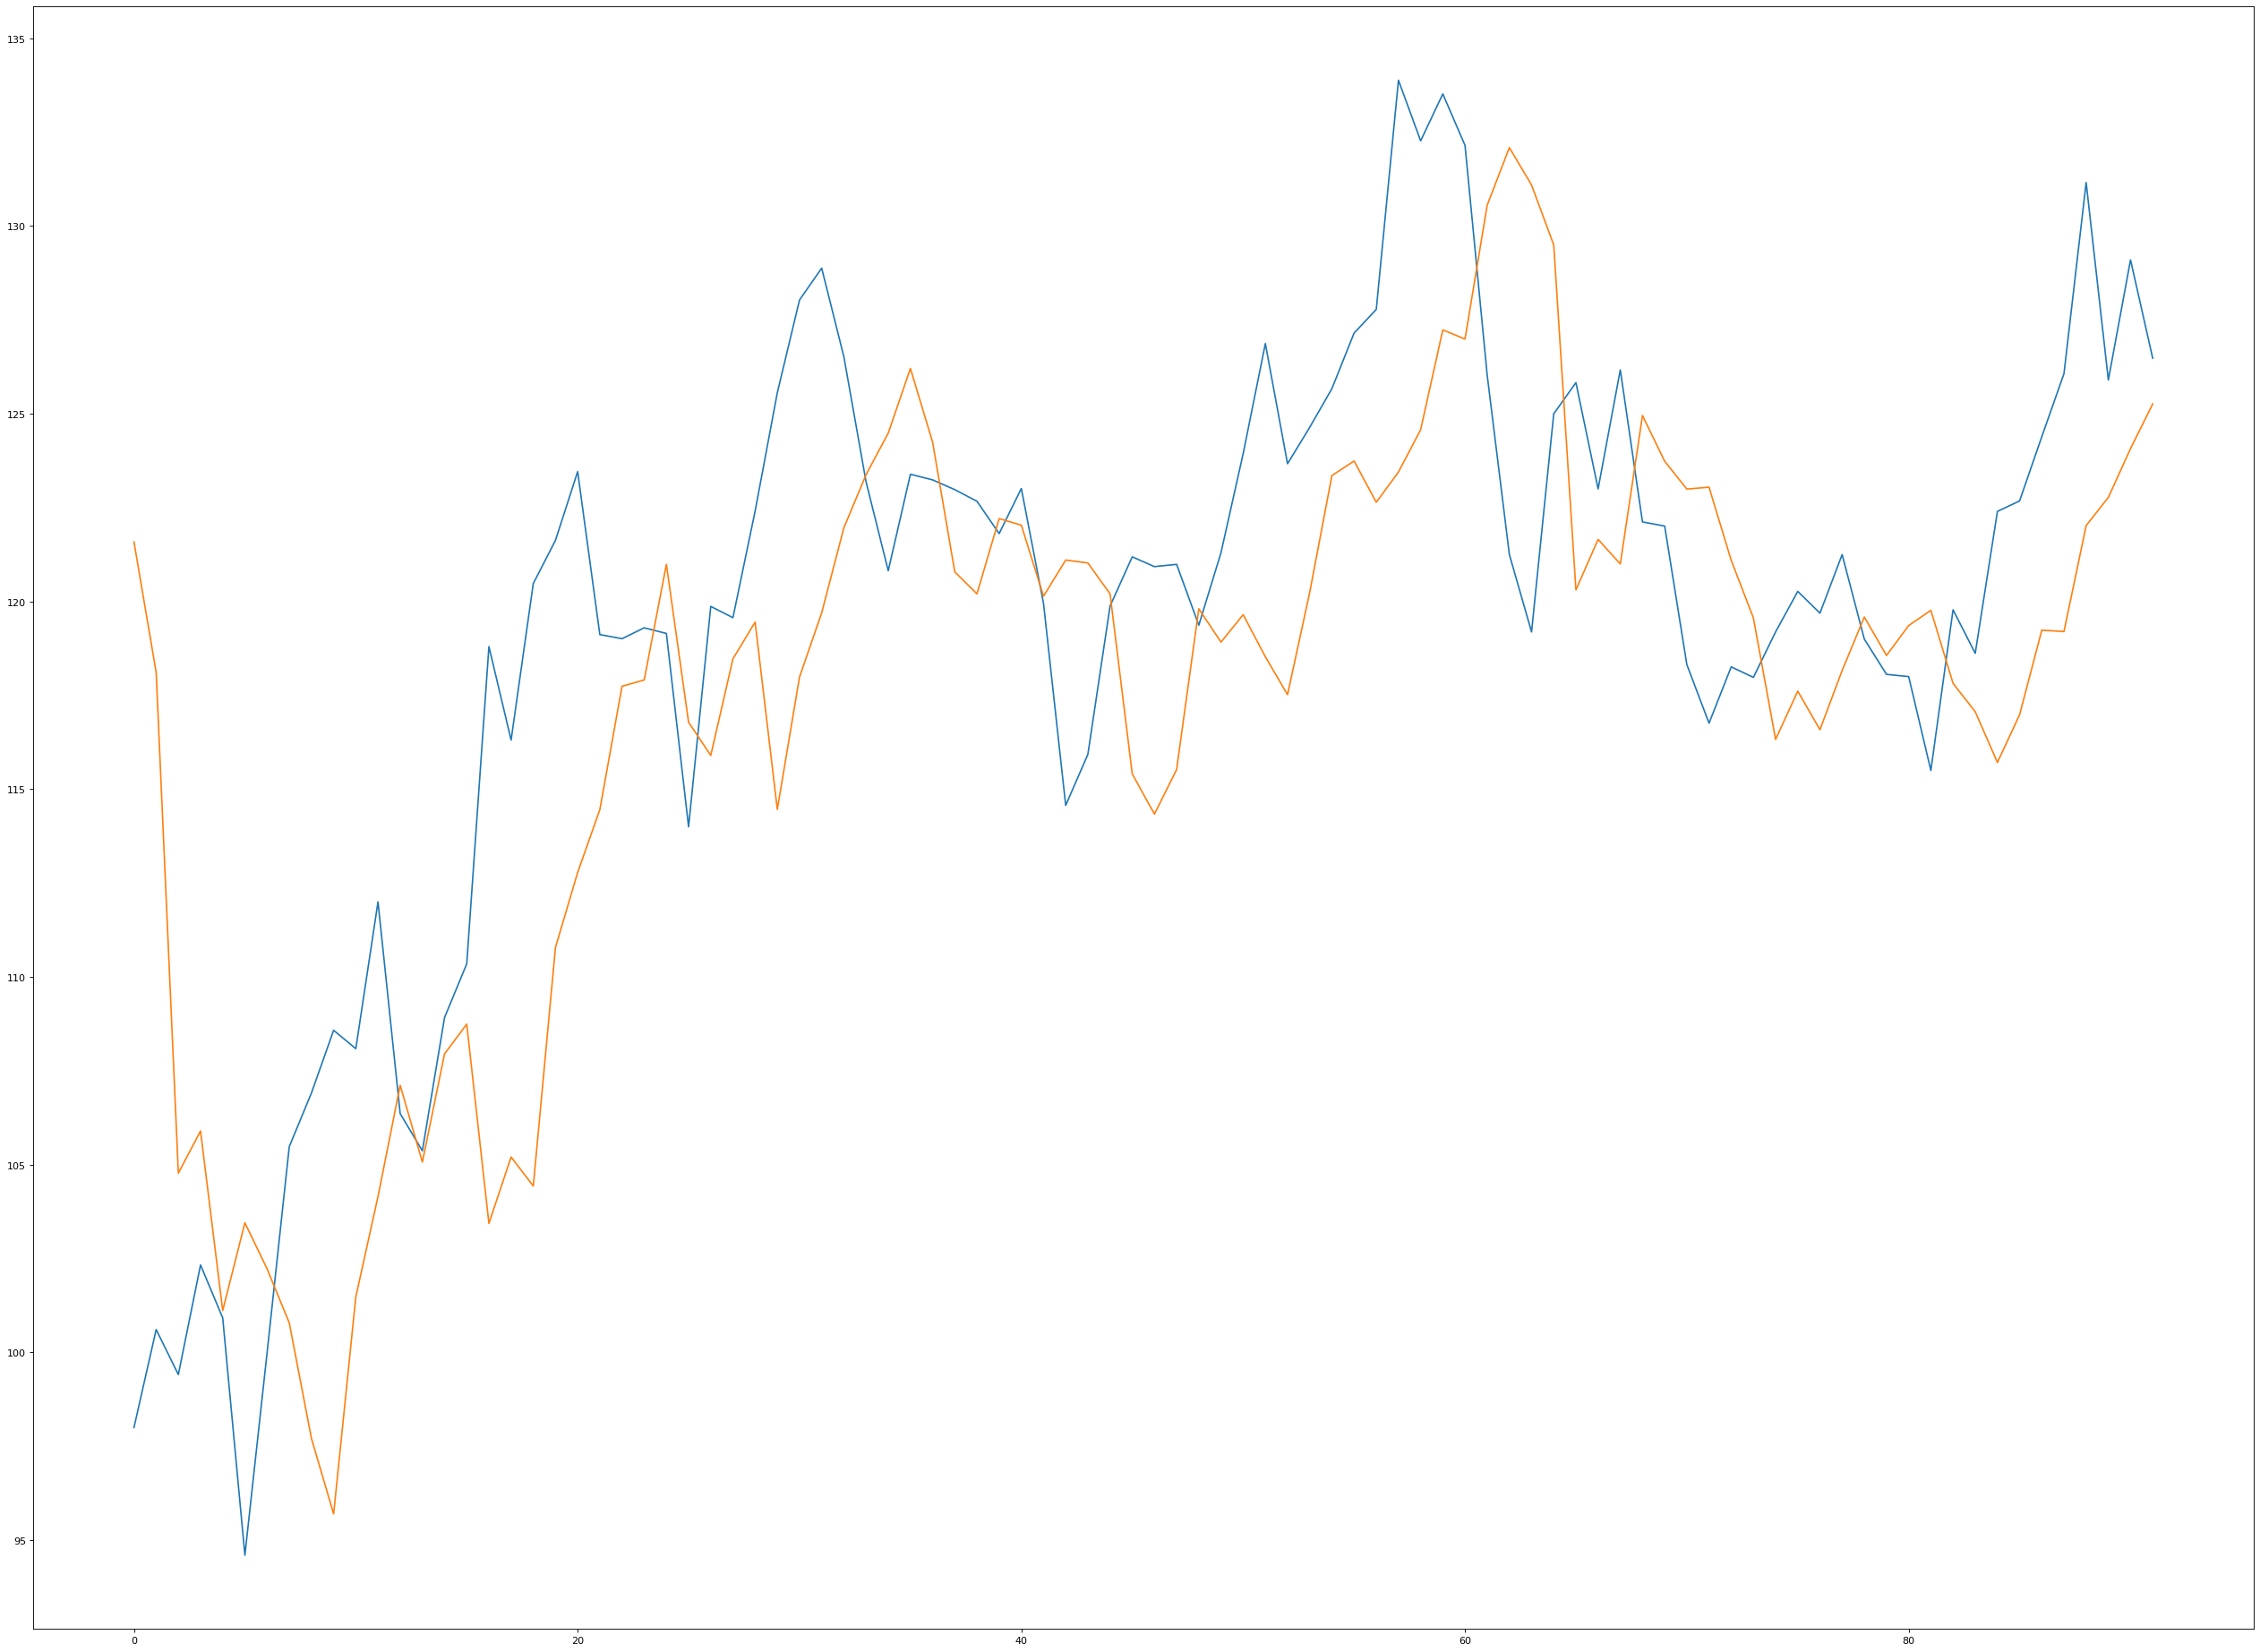

In [33]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(40, 30), dpi=80, facecolor='w', edgecolor='k')

plt.plot(range(92), unscaled_y_test[-92:])
plt.plot(range(92), predicted_y_test[-92:])
plt.show()

##### Last 4 days + prediction of next 4 days

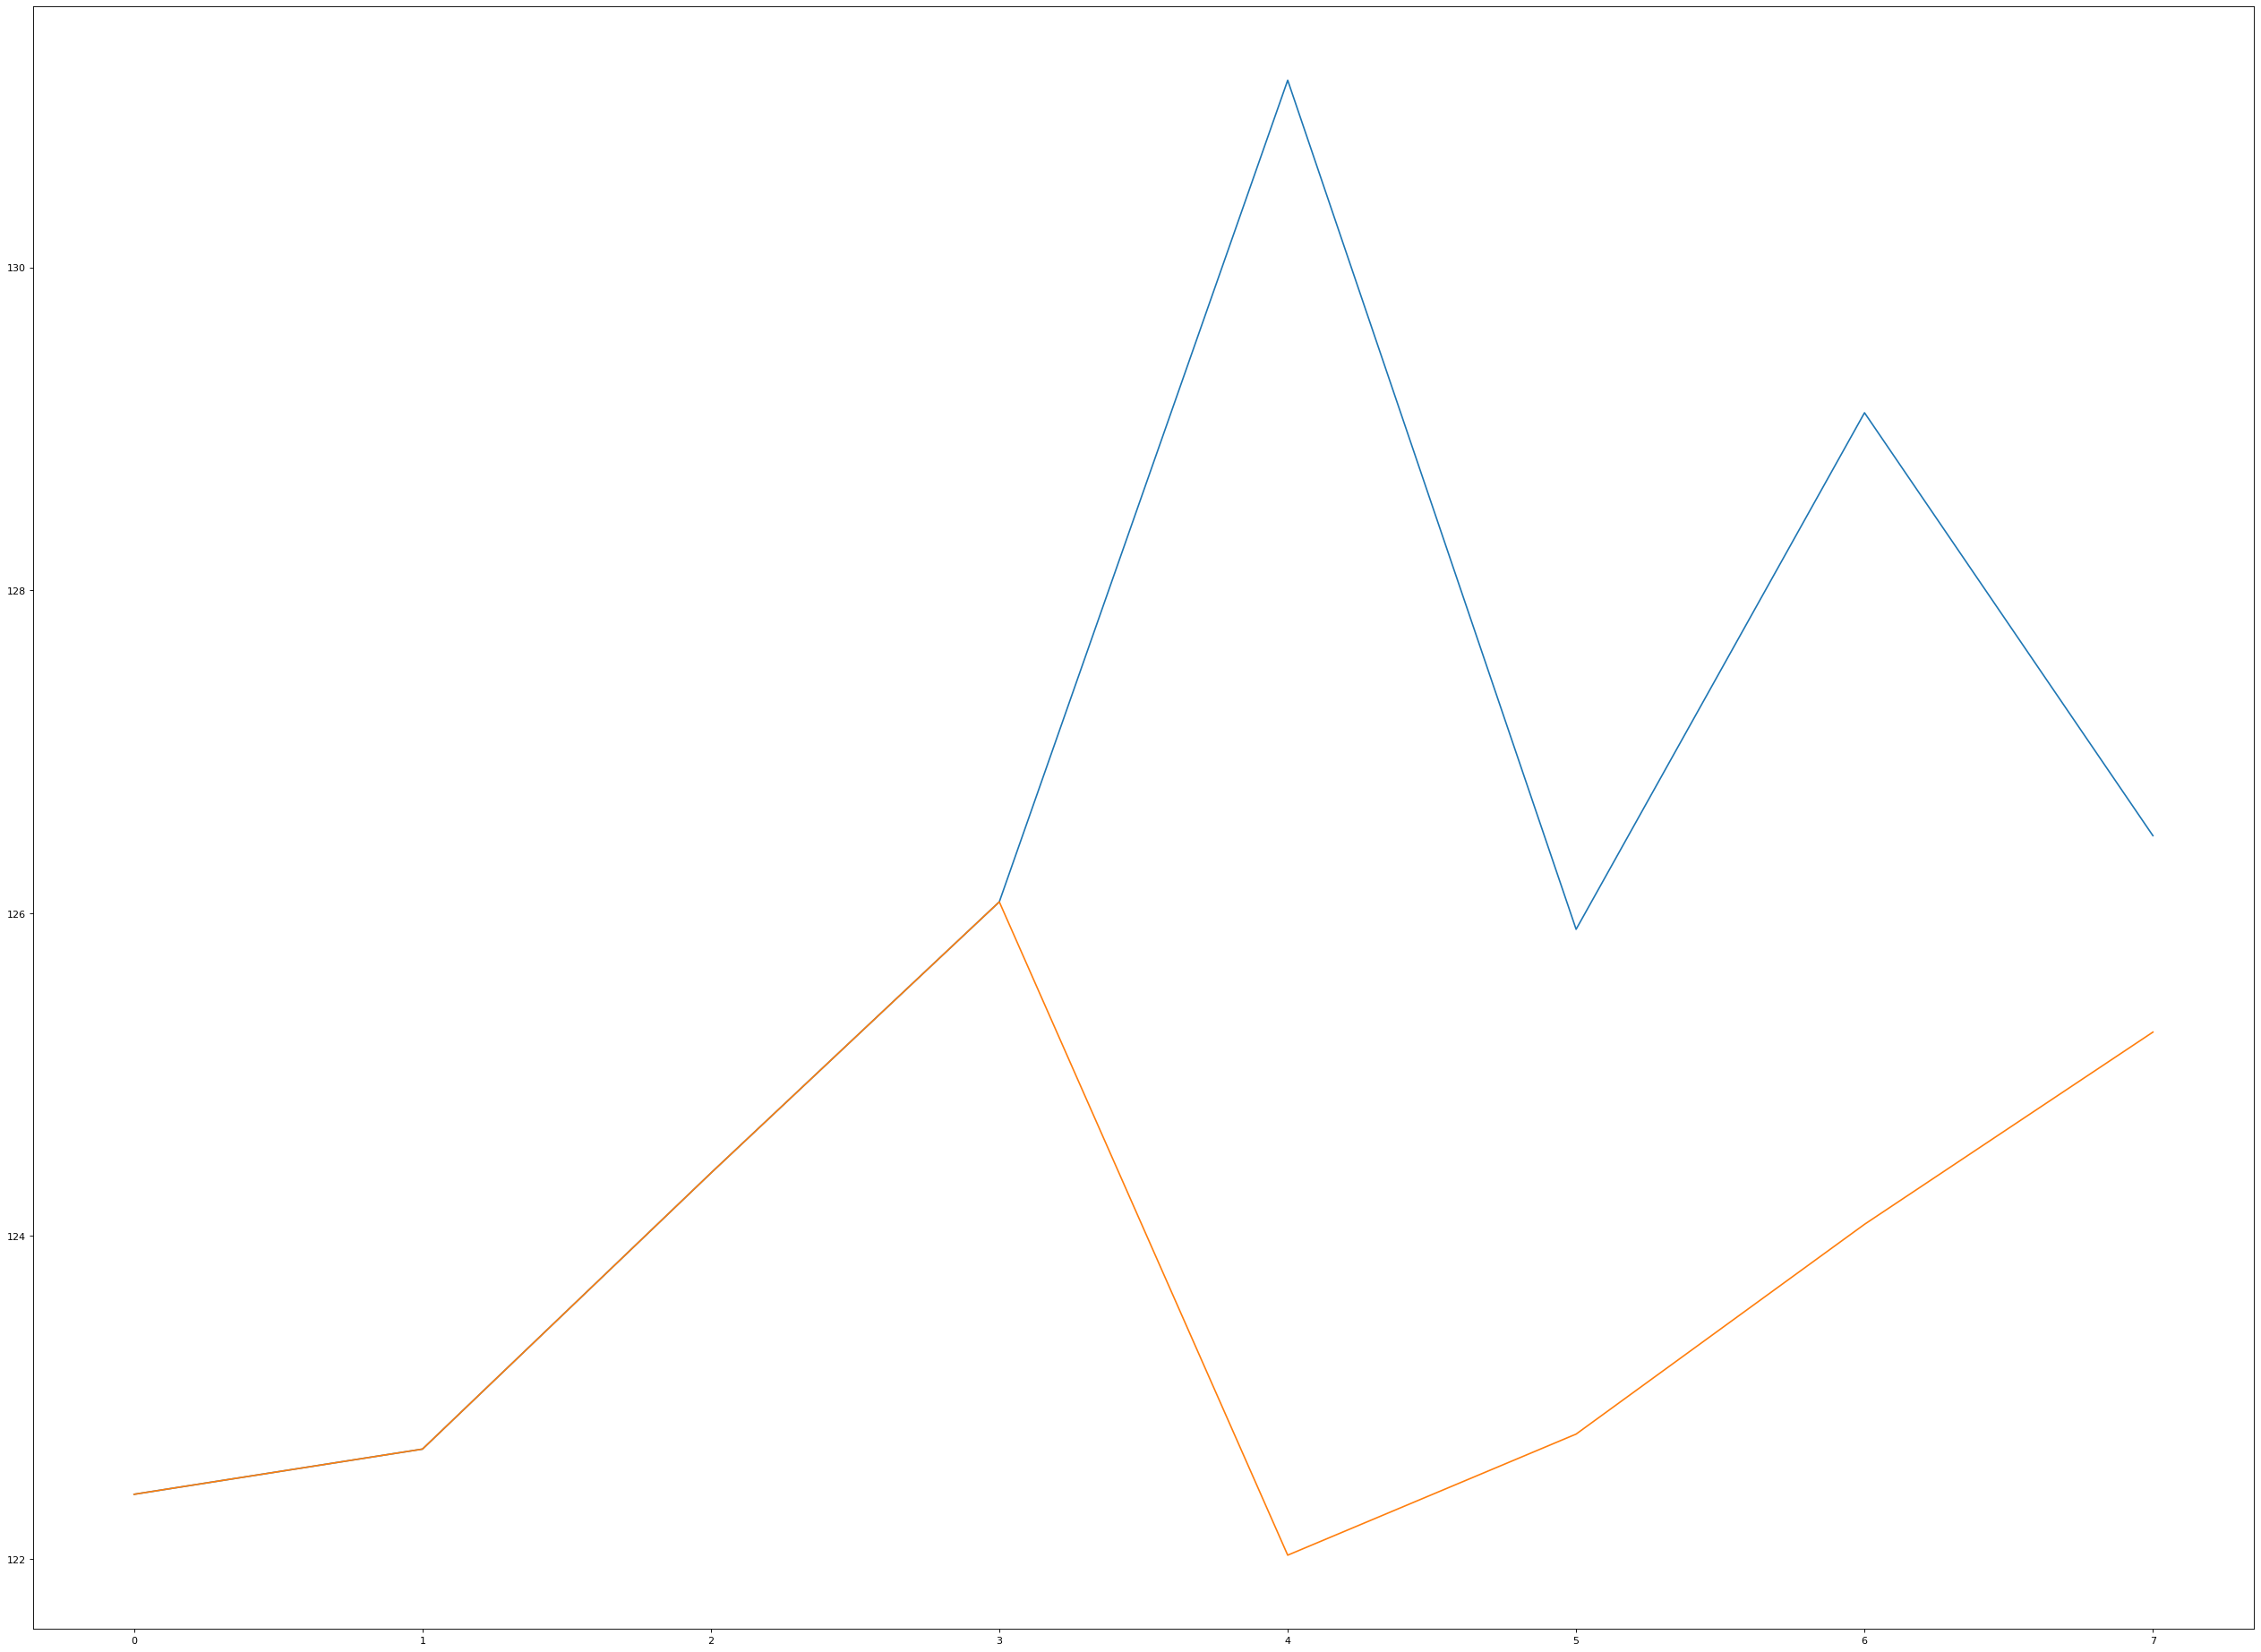

In [34]:
figure(num=None, figsize=(40, 30), dpi=80, facecolor='w', edgecolor='k')

plt.plot(range(8), unscaled_y_test[-8:])
plt.plot(range(8), np.append(unscaled_y_test[-8:-4], predicted_y_test[-4:]))
plt.show()